In [1]:
# set keras 3 backend to pytorch and enable cuda
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
keras.config.set_backend("torch")

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("keras backend:", keras.backend.backend())
print("pytorch cuda available:", torch.cuda.is_available())
print("selected device:", device)

keras backend: torch
pytorch cuda available: True
selected device: cuda


In [2]:
import os, random, numpy as np

np.random.seed(13)
random.seed(13)
import sys, os
sys.path.append(os.path.abspath("../src"))

['date', 'maturity', 'tau', 'S0', 'K', 'rel_strike', 'q', 'r', 'market_iv', 'rf_0', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'rf_6', 'rf_7', 'rf_8', 'rf_9', 'rf_10', 'rf_11', 'rf_12', 'rf_13', 'rf_14', 'rf_15', 'rf_16', 'rf_17', 'rf_18', 'rf_19', 'rf_20', 'rf_21', 'rf_22', 'rf_23', 'rf_24', 'rf_25', 'rf_26', 'rf_27', 'rf_28', 'rf_29', 'rf_30', 'rf_31', 'ssvi_theta', 'ssvi_rho', 'ssvi_beta', 'heston_kappa', 'heston_theta', 'heston_sigma', 'heston_rho', 'heston_v0']
(141790, 49)


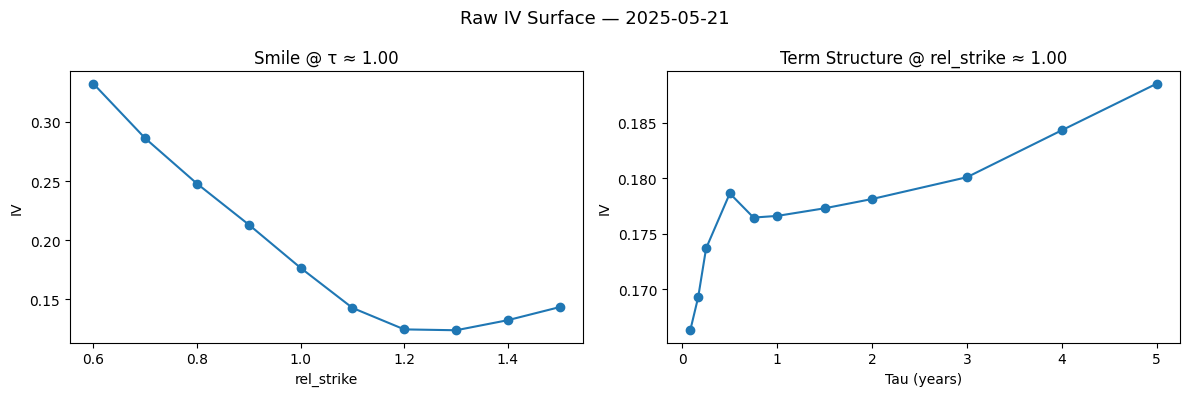

In [3]:
from data.loader import load_and_clean_raw_dataset

df = load_and_clean_raw_dataset("../data/vol_tensor_dataset.csv")

print(df.columns.tolist())
print(df.shape)

# global variables
global LOOKBACK, BATCH_SIZE, LATENT_DIM, SURFACE_SHAPE, FEATURE_DIM
global TARGET_DATE, TARGET_STRIKE, TARGET_TAU

LOOKBACK = 20
BATCH_SIZE = 32
LATENT_DIM = 12
SURFACE_SHAPE = (11, 10)
FEATURE_DIM = LOOKBACK * (11 * 10 + 1 + 32)  

TARGET_DATE = "2025-05-21"
TARGET_STRIKE = 1.0
TARGET_TAU = 1.0

USE_PREPROCESSED_INPUTS = False

from utils.plotting import plot_raw_iv_slice

plot_raw_iv_slice(df, target_date=TARGET_DATE, target_strike=TARGET_STRIKE, target_tau=TARGET_TAU,)

In [4]:
from data.dataset_builder import build_full_surface_feature_df

df_all = build_full_surface_feature_df("../data/vol_tensor_dataset.csv")



print(" Final DataFrame shape:", df_all.shape)
print(" First 5 dates:", df_all.index[:5].tolist())

iv_cols = [c for c in df_all.columns if c.startswith("IV_")]
feat_cols = [c for c in df_all.columns if not c.startswith("IV_")]
df_all = df_all.dropna(subset=feat_cols)

print(" Surface cols:", len(iv_cols), "|  Feature cols:", len(feat_cols))
print("Surface columns (sample):", iv_cols[:5])
print("Feature columns (sample):", feat_cols[:5])

nan_summary = df_all[feat_cols].isna().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
print("Features with NaNs:\n", nan_summary)




 Final DataFrame shape: (1289, 136)
 First 5 dates: [Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-16 00:00:00')]
 Surface cols: 110 |  Feature cols: 26
Surface columns (sample): ['IV_1m_0.60', 'IV_1m_0.70', 'IV_1m_0.80', 'IV_1m_0.90', 'IV_1m_1.00']
Feature columns (sample): ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20']
Features with NaNs:
 Series([], dtype: int64)


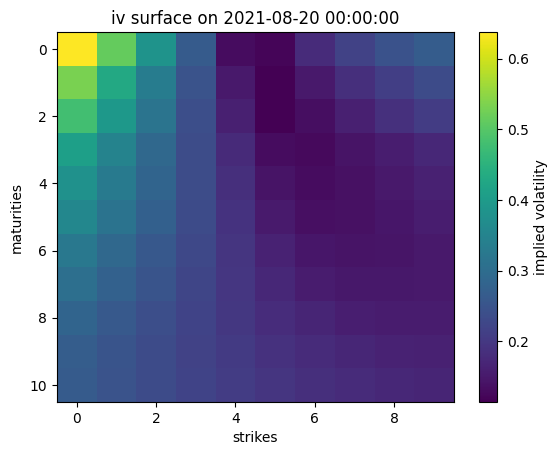


iv surface table on 2021-08-20 00:00:00


strike       0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
maturity                                                                   
18m       0.6376  0.5133  0.3838  0.2646  0.1324  0.1212  0.1786  0.2184   
1m        0.5325  0.4293  0.3344  0.2475  0.1495  0.1147  0.1501  0.1851   
1y        0.4786  0.3935  0.3153  0.2411  0.1601  0.1167  0.1347  0.1615   
2m        0.4097  0.3476  0.2914  0.2358  0.1763  0.1322  0.1286  0.1413   
2y        0.3799  0.3293  0.2828  0.2359  0.1855  0.1433  0.1323  0.1387   
3m        0.3563  0.3141  0.2745  0.2341  0.1908  0.1520  0.1367  0.1385   
3y        0.3249  0.2915  0.2597  0.2276  0.1947  0.1646  0.1467  0.1418   
4y        0.3062  0.2774  0.2501  0.2234  0.1968  0.1725  0.1554  0.1479   
5y        0.2830  0.2605  0.2394  0.2192  0.1998  0.1821  0.1683  0.1592   
6m        0.2697  0.2512  0.2341  0.2182  0.2031  0.1895  0.1785  0.1702   
9m        0.2642  0.2481  0.2333  0.2196  0.2069  0.1955  0.1860  0.1784   

strike       1.4     1.5  
maturity                  
18m       0.2459  0.2661  
1m        0.2127  0.2338  
1y        0.1863  0.2070  
2m        0.1570  0.1729  
2y        0.1498  0.1619  
3m        0.1464  0.1561  
3y        0.1442  0.1496  
4y        0.1477  0.1507  
5y        0.1551  0.1547  
6m        0.1651  0.1627  
9m        0.1728  0.1693

In [5]:
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

# select random date
ix = np.random.randint(len(df_all))
date = df_all.index[ix]

# parse shape from iv column names
maturities = sorted(set(re.search(r"IV_(.*?)_", c).group(1) for c in iv_cols))
strikes = sorted(set(float(re.search(r"_(\d\.\d+)", c).group(1)) for c in iv_cols))

# extract and reshape surface
surface_values = df_all.iloc[ix][iv_cols].values.reshape(len(maturities), len(strikes))

# plot
plt.imshow(surface_values, cmap="viridis", aspect="auto")
plt.title(f"iv surface on {date}")
plt.xlabel("strikes")
plt.ylabel("maturities")
plt.colorbar(label="implied volatility")
plt.show()

# display surface table
surface_df = pd.DataFrame(surface_values, index=maturities, columns=strikes)
surface_df.index.name = "maturity"
surface_df.columns.name = "strike"

print(f"\niv surface table on {date}")
display(surface_df.round(4))

In [6]:
from data.tensor_builder import prepare_surface_and_feature_tensors
from keras import ops

# build vol tensors and interpolation functions
tensors, X_feat_tensor, df_feat = prepare_surface_and_feature_tensors(
    df_all=df_all,
    df_raw=df,
    feat_cols=feat_cols,
    monthly_interpolation=False  # or true
)

# output summary
print("structured tensors loaded and interpolated")
print("surface_tensor shape:", ops.shape(tensors["surface_tensor"]))
print("X_feat_tensor shape:", ops.shape(X_feat_tensor))
print("number of taus:", len(tensors["taus"]))
print("feature columns:", df_feat.columns.tolist())

structured tensors loaded and interpolated
surface_tensor shape: (1258, 11, 10, 6)
X_feat_tensor shape: (1258, 136)
number of taus: 11
feature columns: ['log_return', 'log_return_ma20', 'log_return_z20', 'realized_vol_5d', 'realized_vol_5d_ma20', 'realized_vol_5d_z20', 'rate_0.25y', 'rate_0.5y', 'rate_1y', 'rate_2y', 'rate_3y', 'rate_4y', 'rate_5y', 'rate_10y', 'rate_30y', 'slope_5_10', 'slope_10_30', 'smile_skew', 'smile_convexity', 'ts_level', 'ts_slope', 'ts_curvature', 'ts_weighted', 'ts_short_avg', 'ts_long_avg', 'ts_split_slope']


using 1258 valid samples out of 1258
surface nans: 0 / 138380
features nans: 0 / 171088
combined nans: 0 / 309468
valid rows: 1258 / 1258
pca reconstruction rmse (surface only): 0.0031


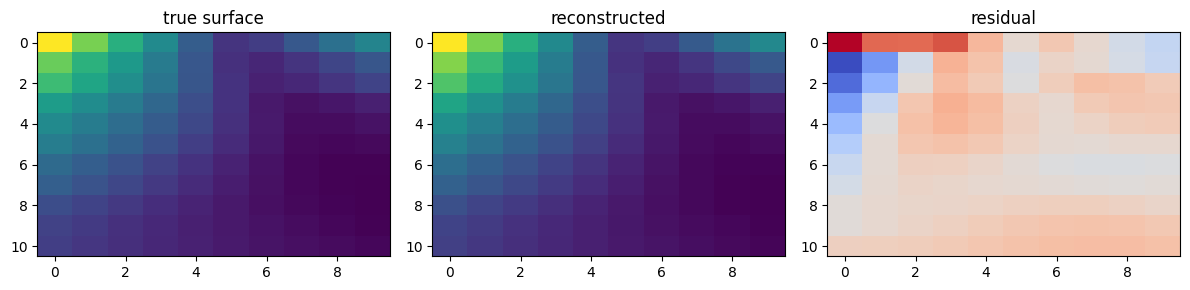

In [7]:
from models.encoder_pca import PCAEncoder
from sklearn.metrics import mean_squared_error
from keras import ops
import numpy as np
import matplotlib.pyplot as plt

# extract tensors to numpy
surface_np = ops.convert_to_numpy(tensors["surface_tensor"])  # (T, M, K, C)
features_np = ops.convert_to_numpy(X_feat_tensor)             # (T, D)
dates_np = tensors["date_tensor"]                             # list of dates

T, M, K, C = surface_np.shape
X_surface = surface_np[..., -1].reshape(T, M * K).astype("float32")
X_features = features_np.astype("float32")

# build combined input
X_combined = np.hstack([X_surface, X_features])  # shape (T, 110 + D)

# find valid rows with no nans
valid_mask = np.all(np.isfinite(X_combined), axis=1)
X_surface_valid = X_surface[valid_mask]
X_combined_valid = X_combined[valid_mask]
dates_valid = np.array(dates_np)[valid_mask]

print(f"using {len(X_combined_valid)} valid samples out of {T}")
# diagnostics
print("surface nans:", np.isnan(X_surface).sum(), "/", X_surface.size)
print("features nans:", np.isnan(X_features).sum(), "/", X_features.size)
print("combined nans:", np.isnan(X_combined).sum(), "/", X_combined.size)
print("valid rows:", valid_mask.sum(), "/", len(valid_mask))

# fit pca
pca = PCAEncoder(n_components=LATENT_DIM)
Z = pca.fit_transform(X_combined_valid)
X_recon = pca.inverse_transform(Z)

# evaluate surface rmse only
X_recon_surface = X_recon[:, :M*K]
rmse_surface = np.sqrt(mean_squared_error(X_surface_valid, X_recon_surface))
print(f"pca reconstruction rmse (surface only): {rmse_surface:.4f}")

# plot example surface
ix = 0  # pick first valid row
X_true = X_surface_valid[ix].reshape(M, K)
X_pred = X_recon_surface[ix].reshape(M, K)
residual = X_true - X_pred

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].imshow(X_true, cmap="viridis", aspect="auto")
axs[0].set_title("true surface")

axs[1].imshow(X_pred, cmap="viridis", aspect="auto")
axs[1].set_title("reconstructed")

axs[2].imshow(residual, cmap="coolwarm", aspect="auto")
axs[2].set_title("residual")

plt.tight_layout()
plt.show()

surface-wise pca-var + features rmse_σ: 0.0023


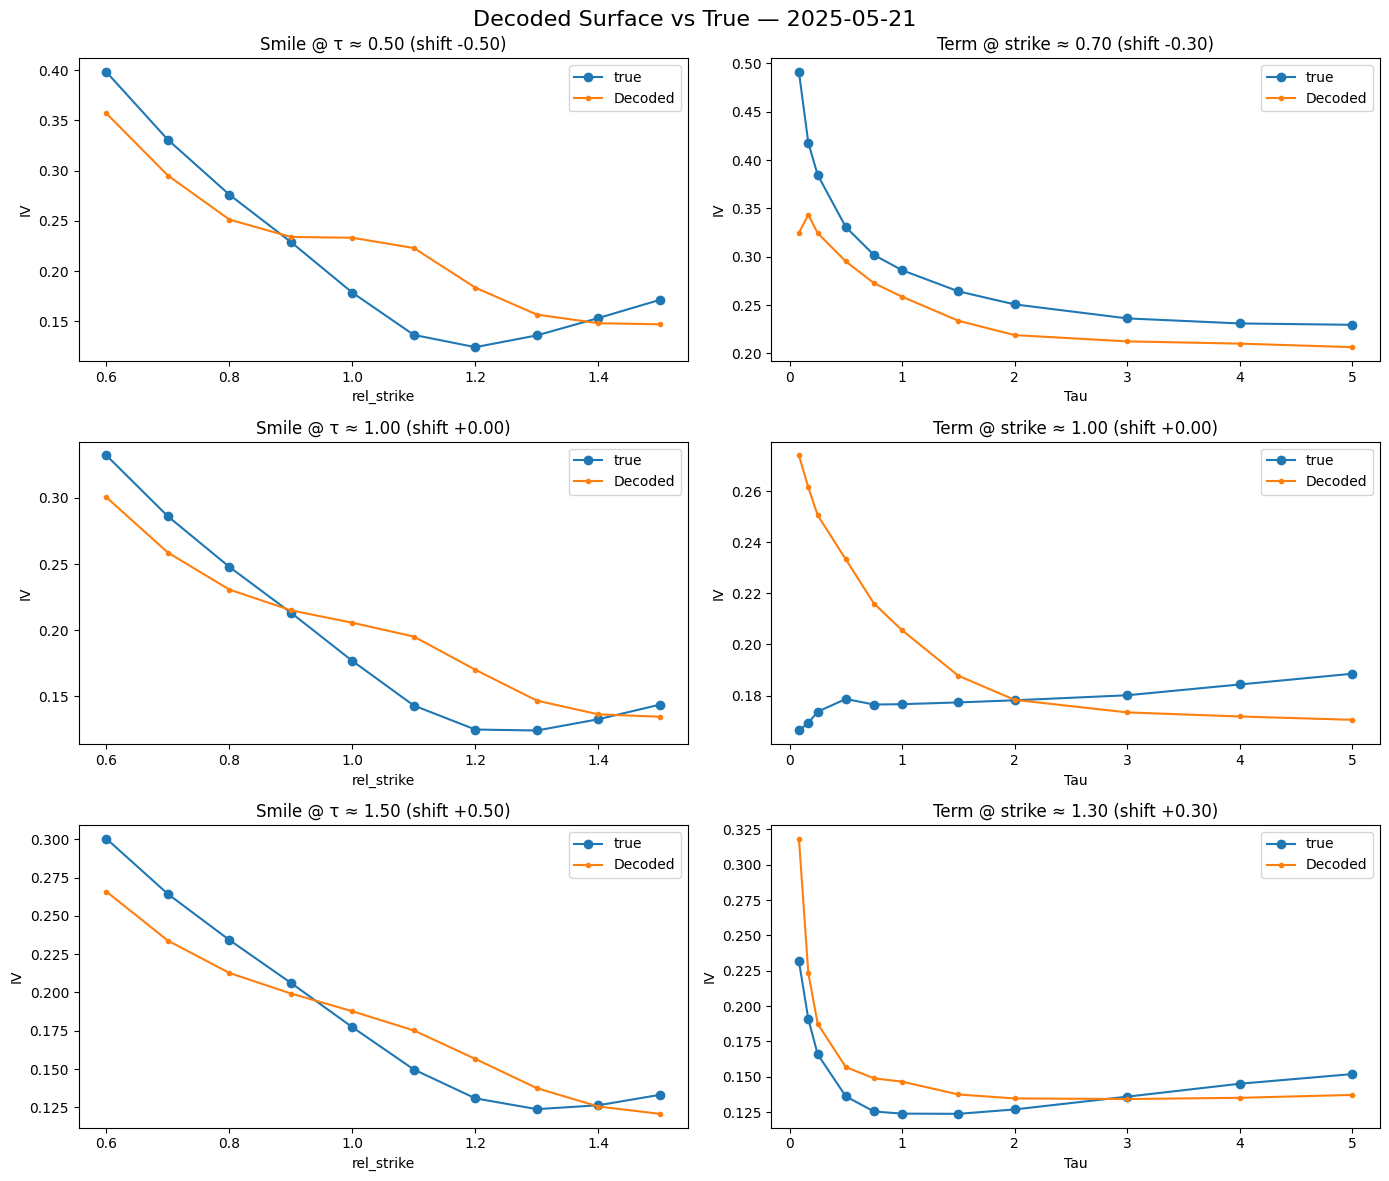

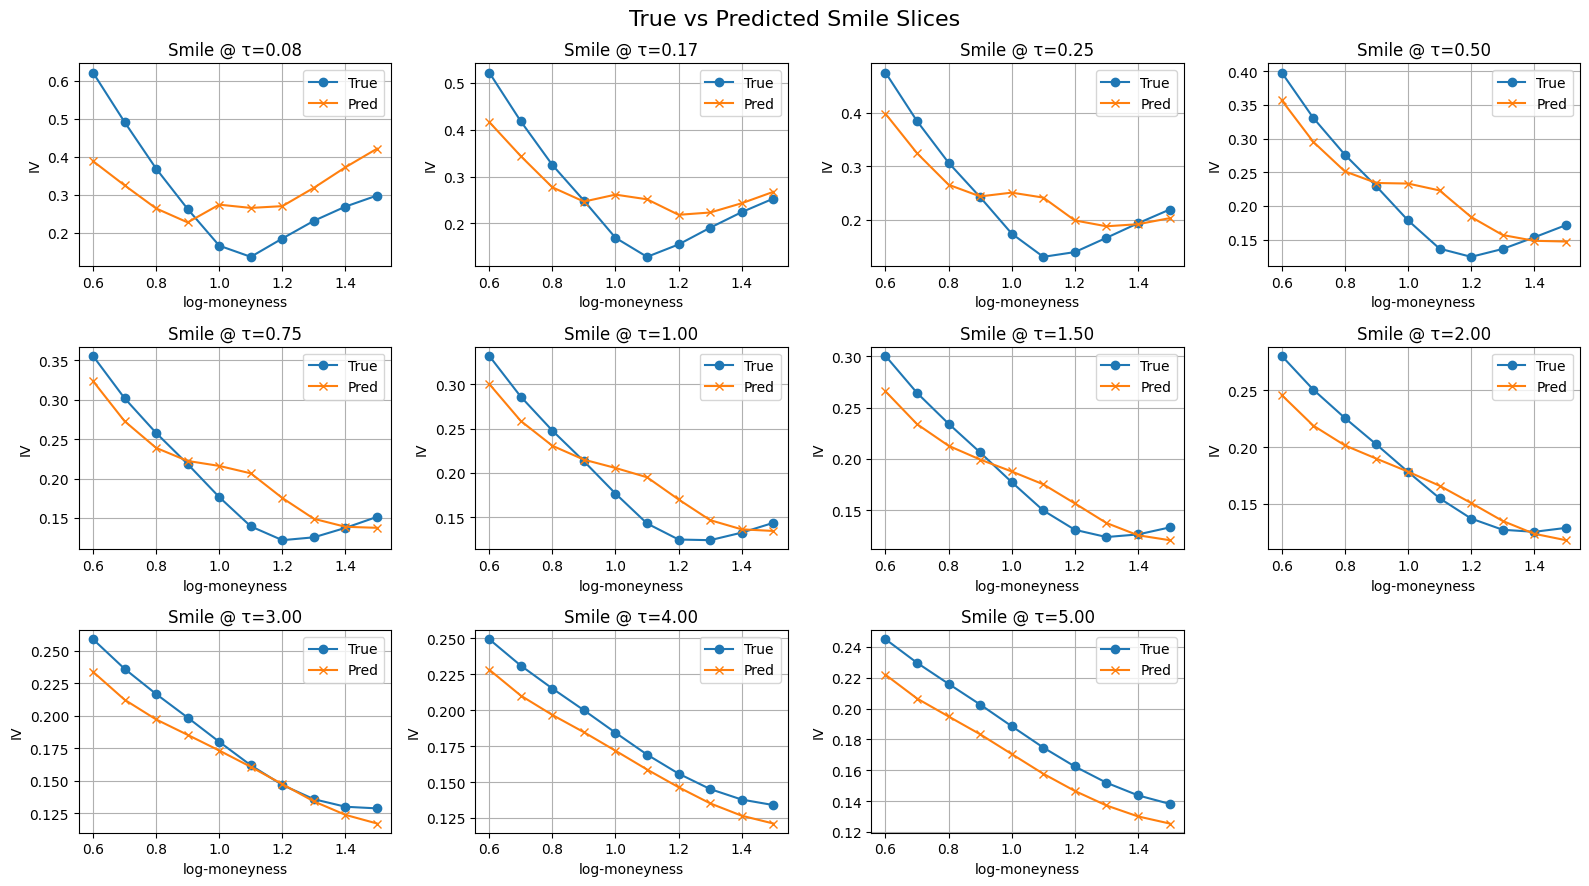

In [8]:
from statsmodels.tsa.api import VAR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from keras import ops
import numpy as np
from utils.plotting import plot_iv_slices_shifts, plot_smile_slices_comparison 

# convert surface tensor: (T, M*K)
iv_surface = ops.convert_to_numpy(tensors["surface_tensor"])[..., -1]
T, M, K = iv_surface.shape
X_flat = iv_surface.reshape(T, M * K).astype(np.float64)

# align features and surface
feature_index = df_feat.index.intersection(df_all.index)
X_df = df_all.loc[feature_index, iv_cols]
F = df_feat.loc[feature_index]  # all features, already cleaned

X_grid = X_df.values.astype(np.float64)
F_aligned = F.values.astype(np.float64)

T = len(X_grid)
T_train = int(0.7 * T)

# demean surfaces
X_mean = X_grid.mean(axis=1, keepdims=True)
X_demeaned = X_grid - X_mean

# pca
pca = PCA(n_components=LATENT_DIM)
Z_all = pca.fit_transform(X_demeaned)
Z_aug = Z

# split
Z_train, Z_test = Z_aug[:T_train], Z_aug[T_train:]
Z_train_pure = Z_all[:T_train]

# var
var_model = VAR(Z_train)
var_results = var_model.fit(maxlags=LOOKBACK)
Z_forecast = var_results.forecast(Z_train[-var_results.k_ar:], steps=len(Z_test))
Z_forecast_pure = Z_forecast[:, :LATENT_DIM]

# decode
X_recon_demeaned = pca.inverse_transform(Z_forecast_pure)
X_mean_forecast = X_mean[T_train:T_train + len(X_recon_demeaned)]
X_recon = X_recon_demeaned + X_mean_forecast
X_true = X_grid[T_train:T_train + len(X_recon)]

# reshape
X_recon = X_recon.reshape(-1, M, K)
X_true = X_true.reshape(-1, M, K)

assert not np.isnan(X_recon).any()
assert not np.isnan(X_true).any()

# rmse
rmse_surface = mean_squared_error(
    X_true.reshape(-1, M * K),
    X_recon.reshape(-1, M * K)
)
print(f"surface-wise pca-var + features rmse_σ: {rmse_surface:.4f}")

# plot last surface
true_surface_t = X_true[-1].reshape(*SURFACE_SHAPE)
recon_surface_t = X_recon[-1].reshape(*SURFACE_SHAPE)

plot_iv_slices_shifts(
    true_surface=true_surface_t,
    decoded_surface=recon_surface_t,
    taus=tensors["taus"],
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    decoded_date=TARGET_DATE,
    target_tau=TARGET_TAU,
    target_strike=TARGET_STRIKE,
)

plot_smile_slices_comparison(
    true_surface=true_surface_t,
    pred_surface=recon_surface_t,
    rel_strikes=ops.convert_to_numpy(tensors["strike_tensor"]),
    taus=tensors["taus"],
)

In [9]:
import importlib
import models.lstm
importlib.reload (models.lstm)
from models.lstm import build_z_sequences_augmented, build_lstm_forecaster_augmented

lookback = LOOKBACK
X_seq, y_seq = build_z_sequences_augmented(Z_aug, lookback, LATENT_DIM)
lr = 5e-4

input_dim = Z_aug.shape[-1]
lstm_model = build_lstm_forecaster_augmented(
    lookback=lookback,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    lr=lr
)

lstm_model.summary()


Model: "lstm_forecaster_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ latent_sequence_input           │ (None, 20, 12)         │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,548 (256.05 KB)

 Trainable params: 65,548 (256.05 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

os.makedirs("saved_models/lstm", exist_ok=True)

new_optimizer = Adam(learning_rate=lr)
lstm_model.compile(optimizer=new_optimizer, loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/lstm/lstm_pca.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

history_lstm = lstm_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

lstm_model.save("saved_models/lstm/lstm_model_pca.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1933 - val_loss: 0.2097 - learning_rate: 5.0000e-04
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1820 - val_loss: 0.2004 - learning_rate: 5.0000e-04
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1795 - val_loss: 0.1975 - learning_rate: 5.0000e-04
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1763 - val_loss: 0.1945 - learning_rate: 5.0000e-04
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1741 - val_loss: 0.1917 - learning_rate: 5.0000e-04
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1714 - val_loss: 0.1889 - learning_rate: 5.0000e-04
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1692 - val_loss: 0.1863 - learning_rate: 5.0000e-04
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1663 - val_loss: 0.1836 - learning_rate: 5.0000e-04
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1634 - val_loss: 0.1809 - 

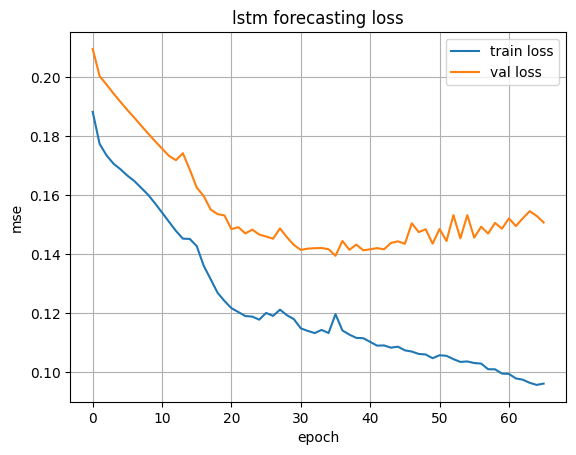

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_lstm.history["loss"], label="train loss")
plt.plot(history_lstm.history["val_loss"], label="val loss")
plt.title("lstm forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  LSTM-PCA           0.12032             0.12032            0.918094   

   acf_diff_mean  var_ratio_pred/true  
0       0.173049             0.406851

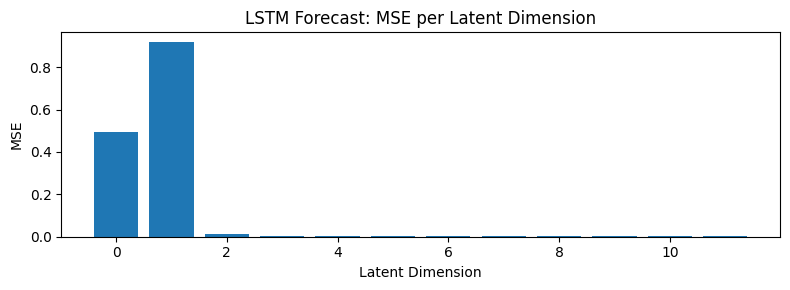

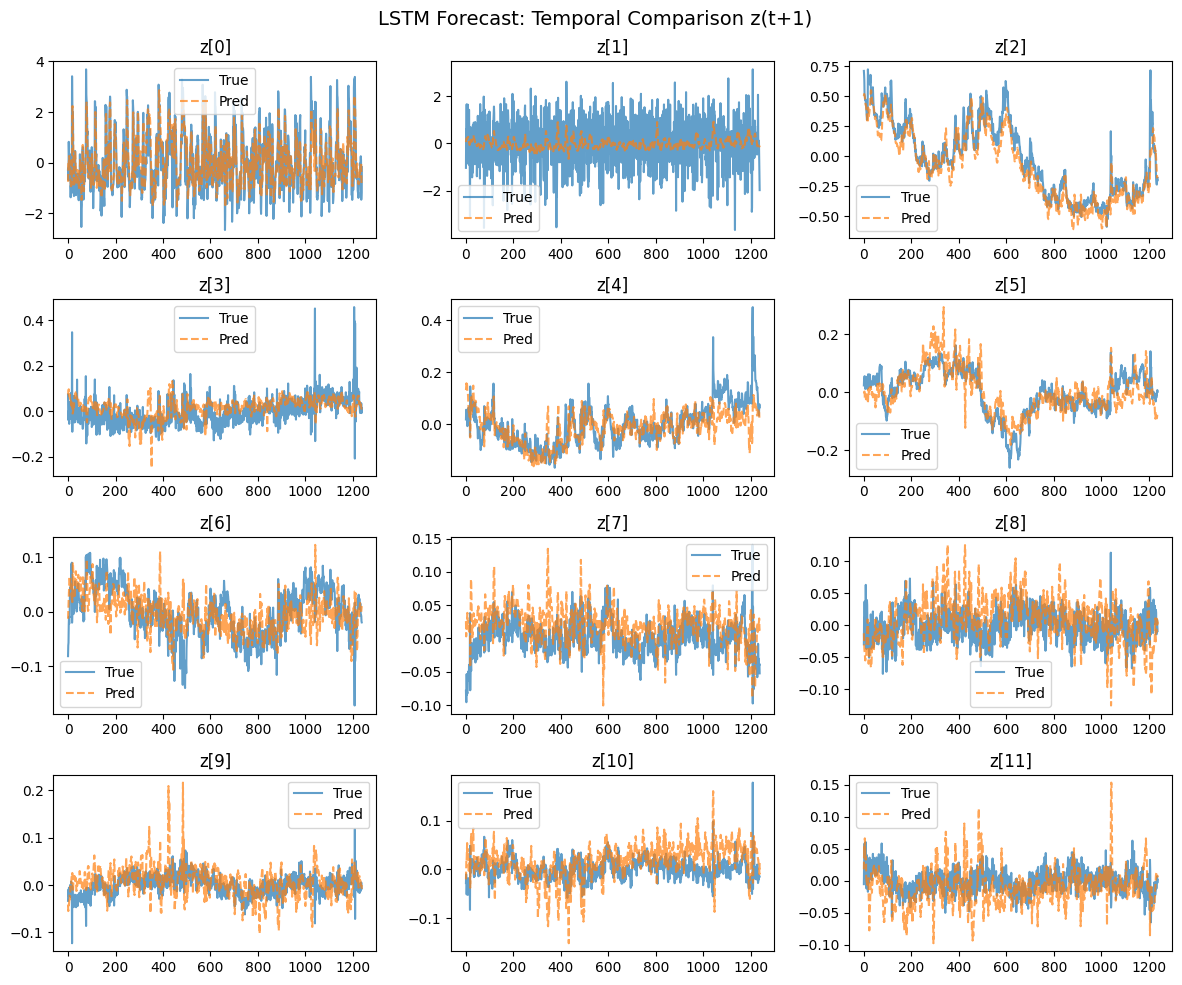

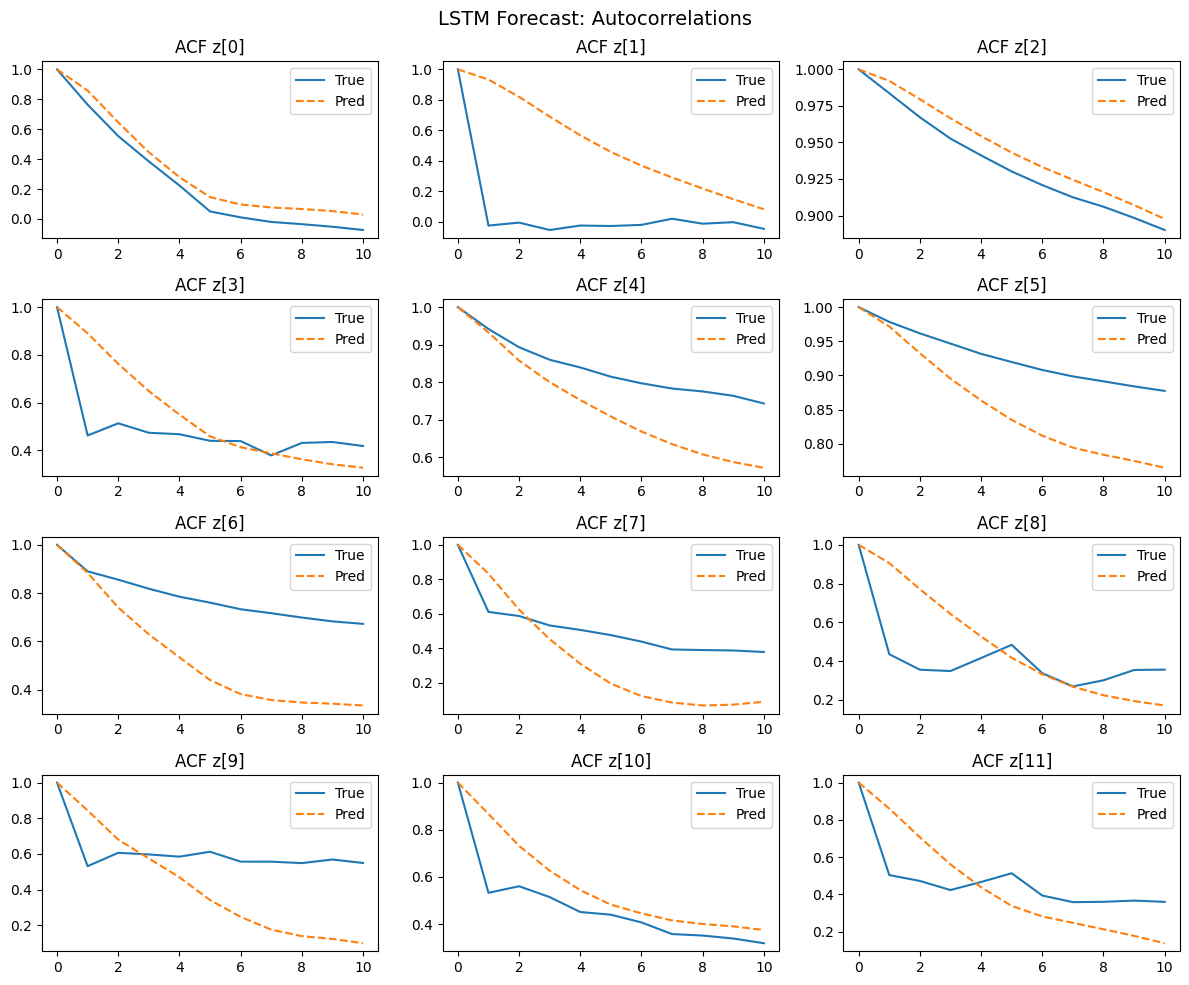

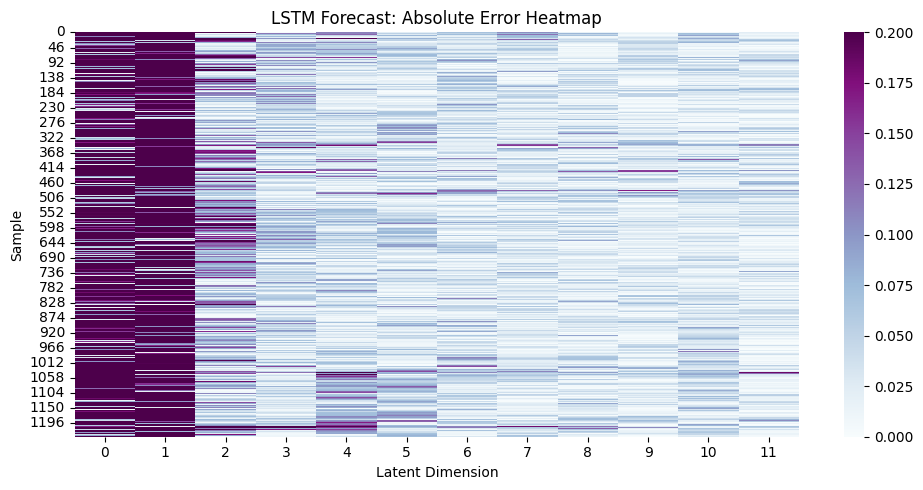

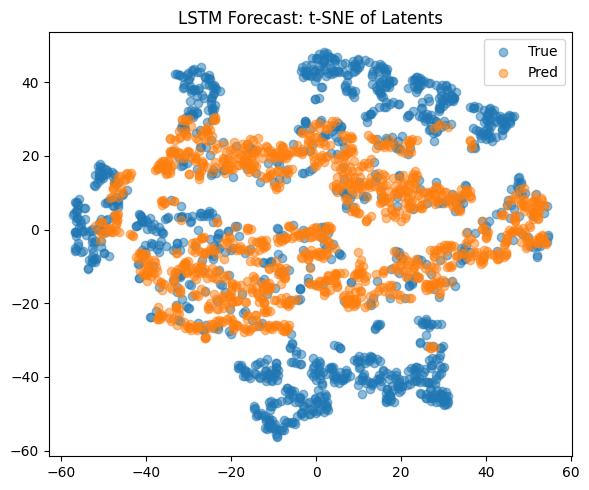

In [12]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # if split use y_test
Z_pred = lstm_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_lstm = summarize_latent_errors(Z_true, Z_pred, name="LSTM-PCA")
display(summary_lstm)


plot_latent_diagnostics(Z_true, Z_pred, name="LSTM Forecast", tsne=True)



In [13]:
import importlib
import models.lstm
importlib.reload (models.lstm)
from models.lstm import build_z_sequences_augmented, build_lstm_with_attention_augmented

lookback = LOOKBACK
X_seq, y_seq = build_z_sequences_augmented(Z_aug, lookback, LATENT_DIM)
lr = 5e-4

input_dim = Z_aug.shape[-1]
lstm_model = build_lstm_with_attention_augmented(
    lookback=lookback,
    input_dim=input_dim,
    latent_dim=LATENT_DIM,
    lr=lr
)

lstm_model.summary()


Model: "lstm_with_attention_augmented"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_sequence_in… │ (None, 20, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 20, 64)    │     19,712 │ latent_sequence_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 20, 64)    │     33,024 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 20, 32)    │     12,416 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 32)    │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32)        │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_output (Dense)    │ (None, 12)        │        396 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,548 (256.05 KB)

 Trainable params: 65,548 (256.05 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

os.makedirs("saved_models/lstm_attn", exist_ok=True)

new_optimizer = Adam(learning_rate=lr)
lstm_model.compile(optimizer=new_optimizer, loss="mse")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/lstm_attn/lstm_pca.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

history_lstm_attn = lstm_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

lstm_model.save("saved_models/lstm_attn/lstm_model_pca.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1973 - val_loss: 0.2246 - learning_rate: 5.0000e-04
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1903 - val_loss: 0.2158 - learning_rate: 5.0000e-04
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1864 - val_loss: 0.2129 - learning_rate: 5.0000e-04
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.1851 - val_loss: 0.2138 - learning_rate: 5.0000e-04
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1847 - val_loss: 0.2145 - learning_rate: 5.0000e-04
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1834 - val_loss: 0.2151 - learning_rate: 5.0000e-04
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1826 - val_loss: 0.2155 - learning_rate: 5.0000e-04
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1814 - val_loss: 0.2155 - learning_rate: 5.0000e-04
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.1802 - val_loss: 0.2151 - 

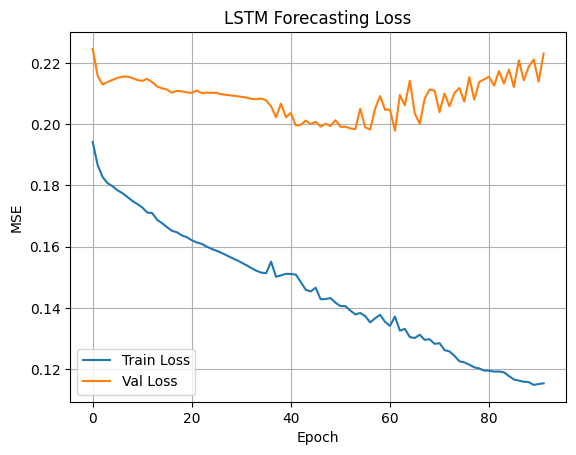

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_lstm_attn.history["loss"], label="Train Loss")
plt.plot(history_lstm_attn.history["val_loss"], label="Val Loss")
plt.title("LSTM Forecasting Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  LSTM w/ attn-PCA          0.144562            0.144562            0.907643   

   acf_diff_mean  var_ratio_pred/true  
0       0.122971             0.258516

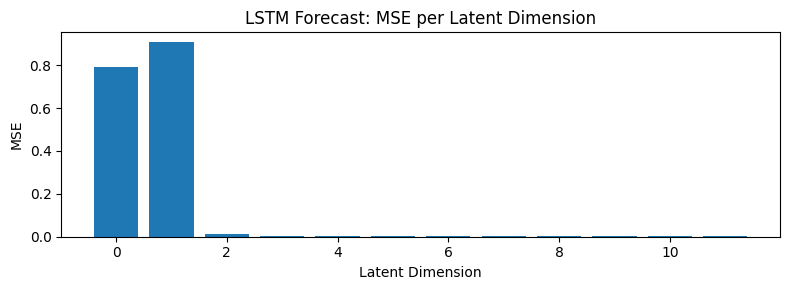

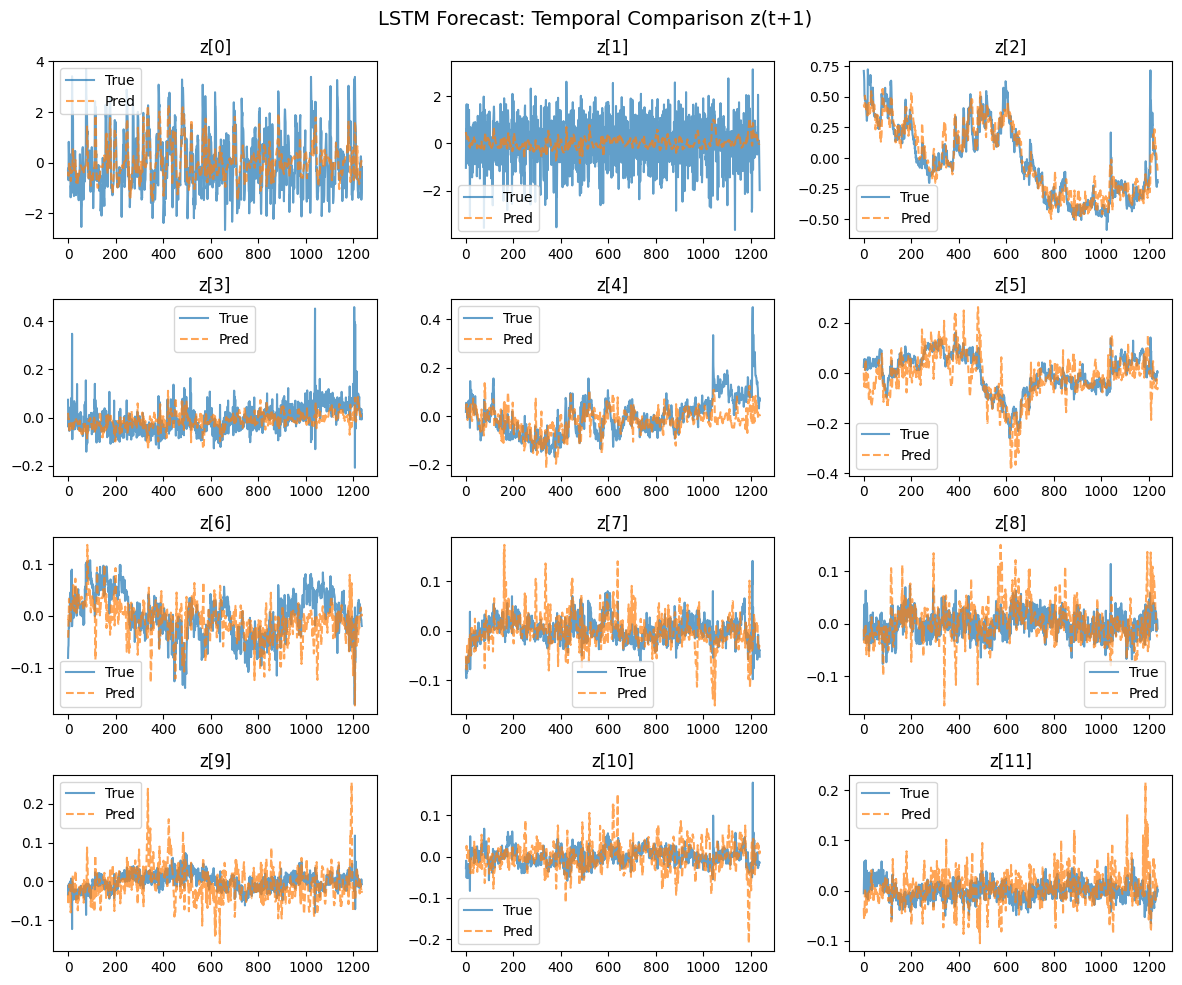

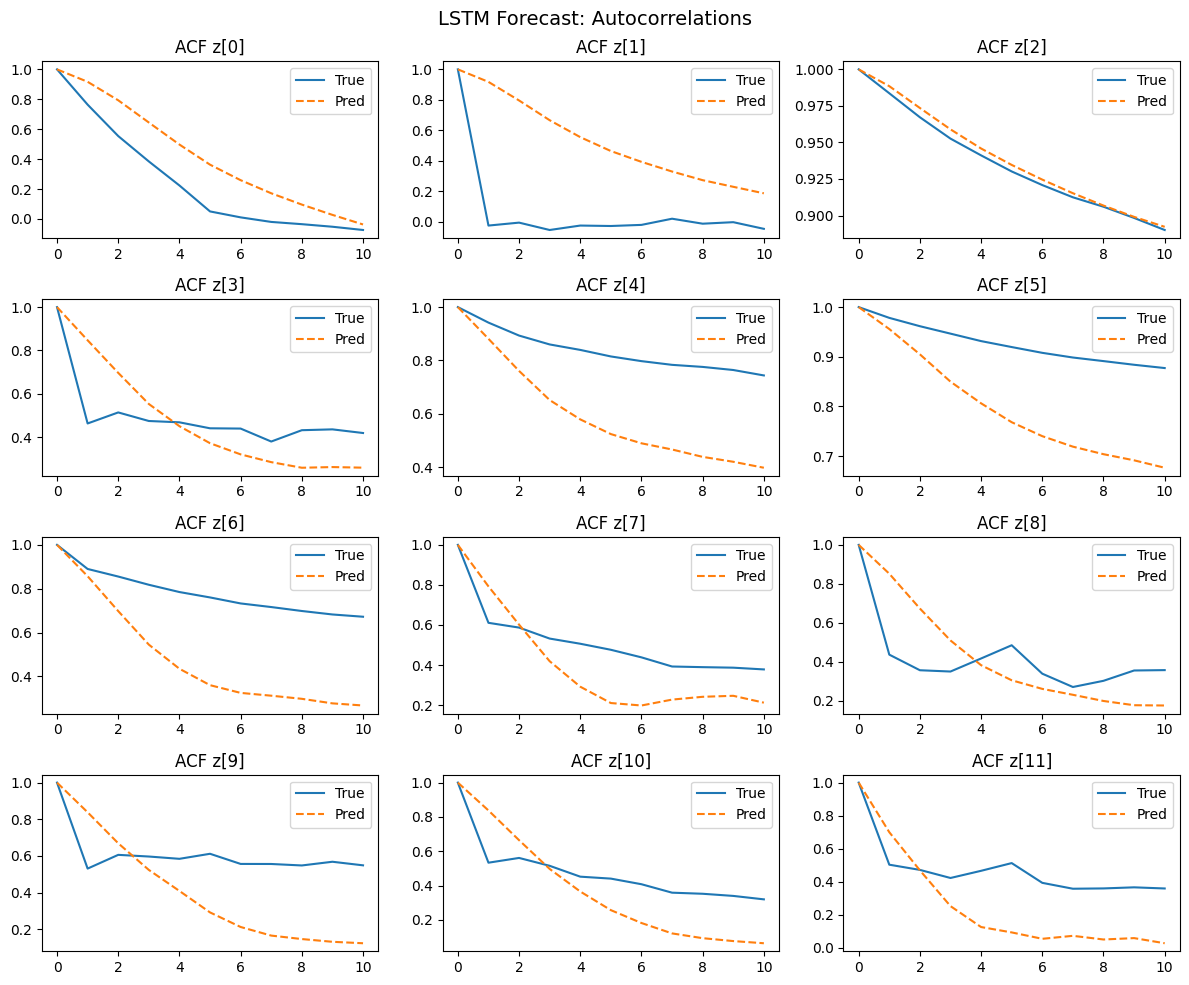

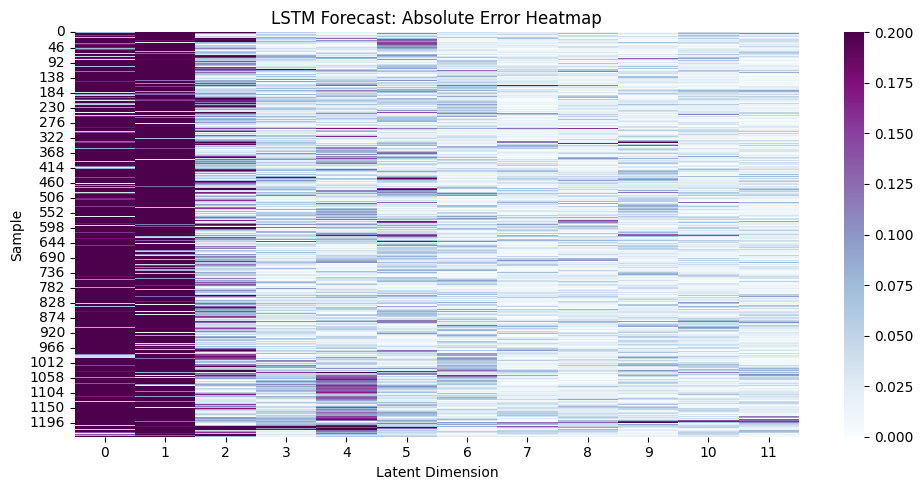

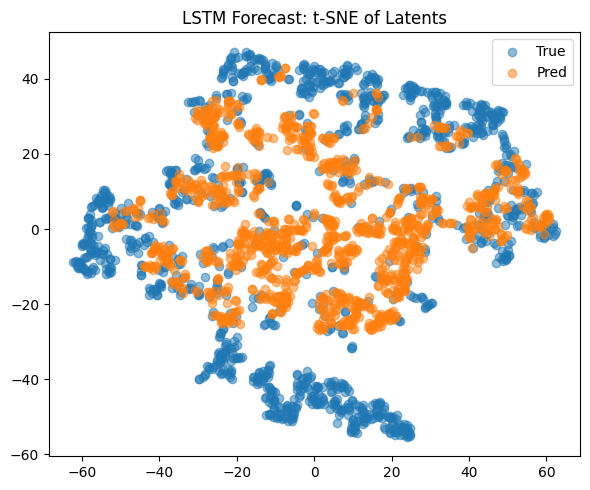

In [16]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # if split use y_test
Z_pred = lstm_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_lstm_attn = summarize_latent_errors(Z_true, Z_pred, name="LSTM w/ attn-PCA")
display(summary_lstm_attn)


plot_latent_diagnostics(Z_true, Z_pred, name="LSTM Forecast", tsne=True)



In [17]:
import pandas as pd

def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    # 
)

display(summary_all)



model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0          LSTM-PCA          0.120320            0.120320            0.918094   
1  LSTM w/ attn-PCA          0.144562            0.144562            0.907643   

   acf_diff_mean  var_ratio_pred/true  
0       0.173049             0.406851  
1       0.122971             0.258516

In [18]:
import importlib
import models.transformer
importlib.reload(models.transformer)


from models.transformer import build_attention_forecaster

attention_model = build_attention_forecaster(
    lookback=LOOKBACK,
    input_dim=LATENT_DIM,  # since z_seq already encodes [surface + features]
    latent_dim=LATENT_DIM,
    lr=5e-4
)

attention_model.summary()


Model: "attention_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 20, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 12)    │         24 │ sequence_input[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 12)    │      2,460 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 12)    │          0 │ sequence_input[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 12)    │         24 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 12)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 12)        │          0 │ dropout_1[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        832 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_output (Dense)    │ (None, 12)        │        780 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,120 (16.09 KB)

 Trainable params: 4,120 (16.09 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# --- Create output directory ---
os.makedirs("saved_models/attention", exist_ok=True)

# --- Compile (redundant if already compiled)
new_optimizer = Adam(learning_rate=lr)
attention_model.compile(optimizer=new_optimizer, loss="mse")

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/attention/attention_pca.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

# --- Fit model ---
history_attention = attention_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

# --- Save full model ---
attention_model.save("saved_models/attention/attention_model_pca.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2389 - val_loss: 0.2438 - learning_rate: 5.0000e-04
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1994 - val_loss: 0.2298 - learning_rate: 5.0000e-04
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1928 - val_loss: 0.2255 - learning_rate: 5.0000e-04
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1875 - val_loss: 0.2225 - learning_rate: 5.0000e-04
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1844 - val_loss: 0.2205 - learning_rate: 5.0000e-04
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1817 - val_loss: 0.2192 - learning_rate: 5.0000e-04
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1798 - val_loss: 0.2178 - learning_rate: 5.0000e-04
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1783 - val_loss: 0.2173 - learning_rate: 5.0000e-04
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1769 - val_loss: 0.2165 - learning_

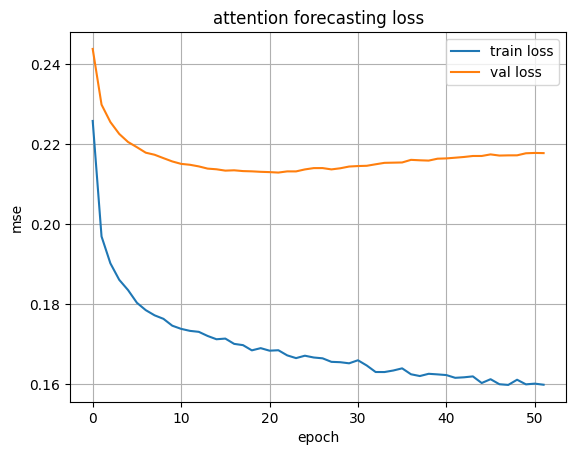

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_attention.history["loss"], label="train loss")
plt.plot(history_attention.history["val_loss"], label="val loss")
plt.title("attention forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  \
0  Attention-only PCA          0.174901            0.174901   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            1.134727       0.226248             0.129303

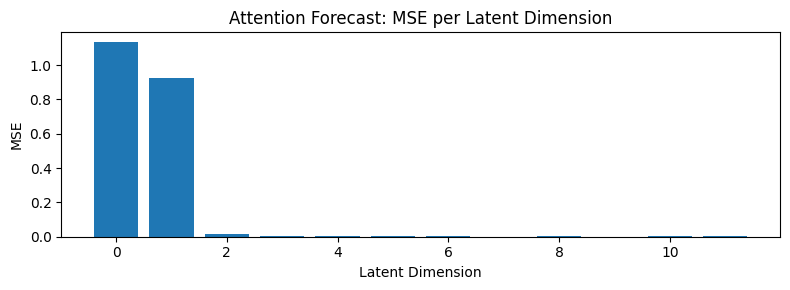

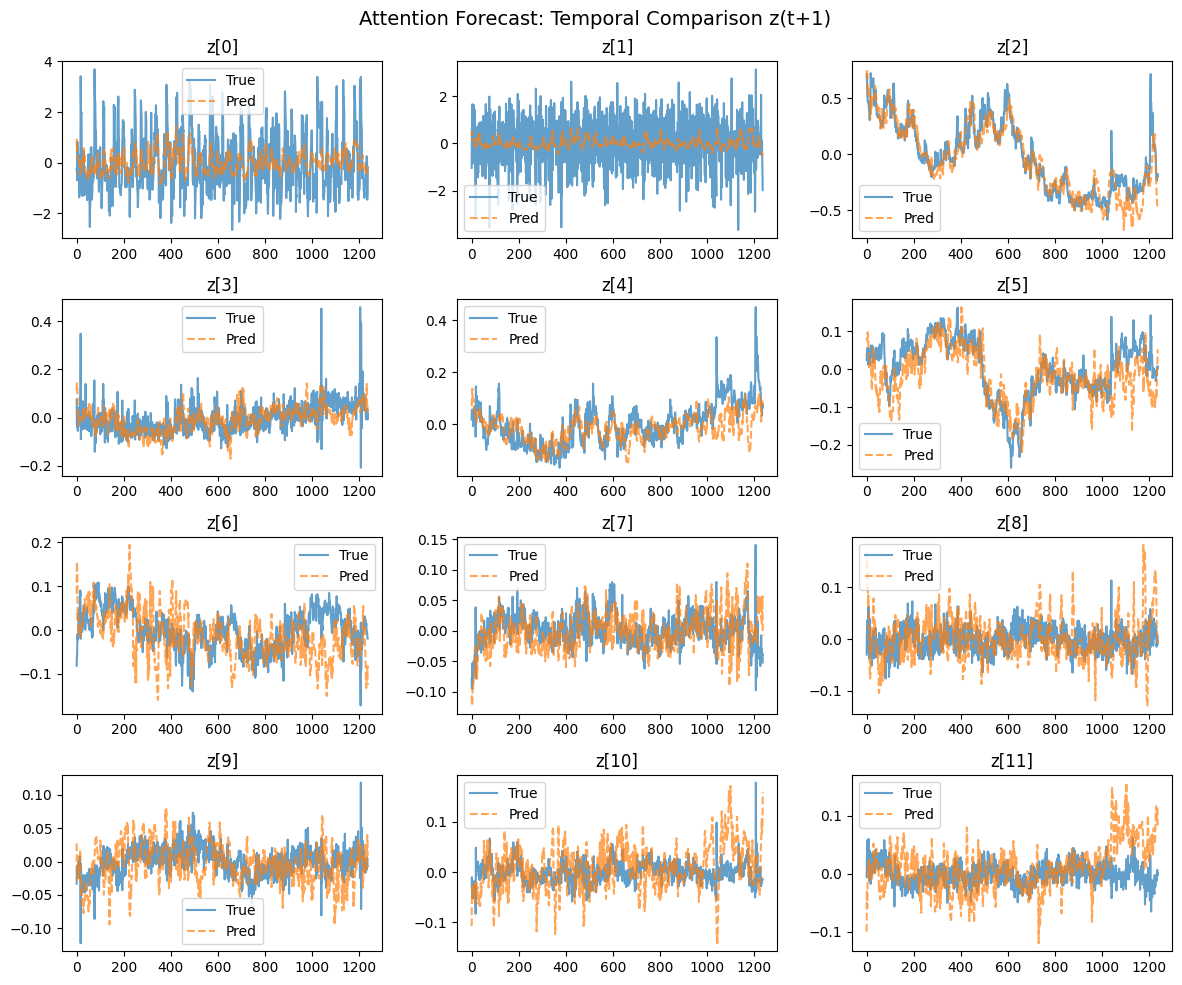

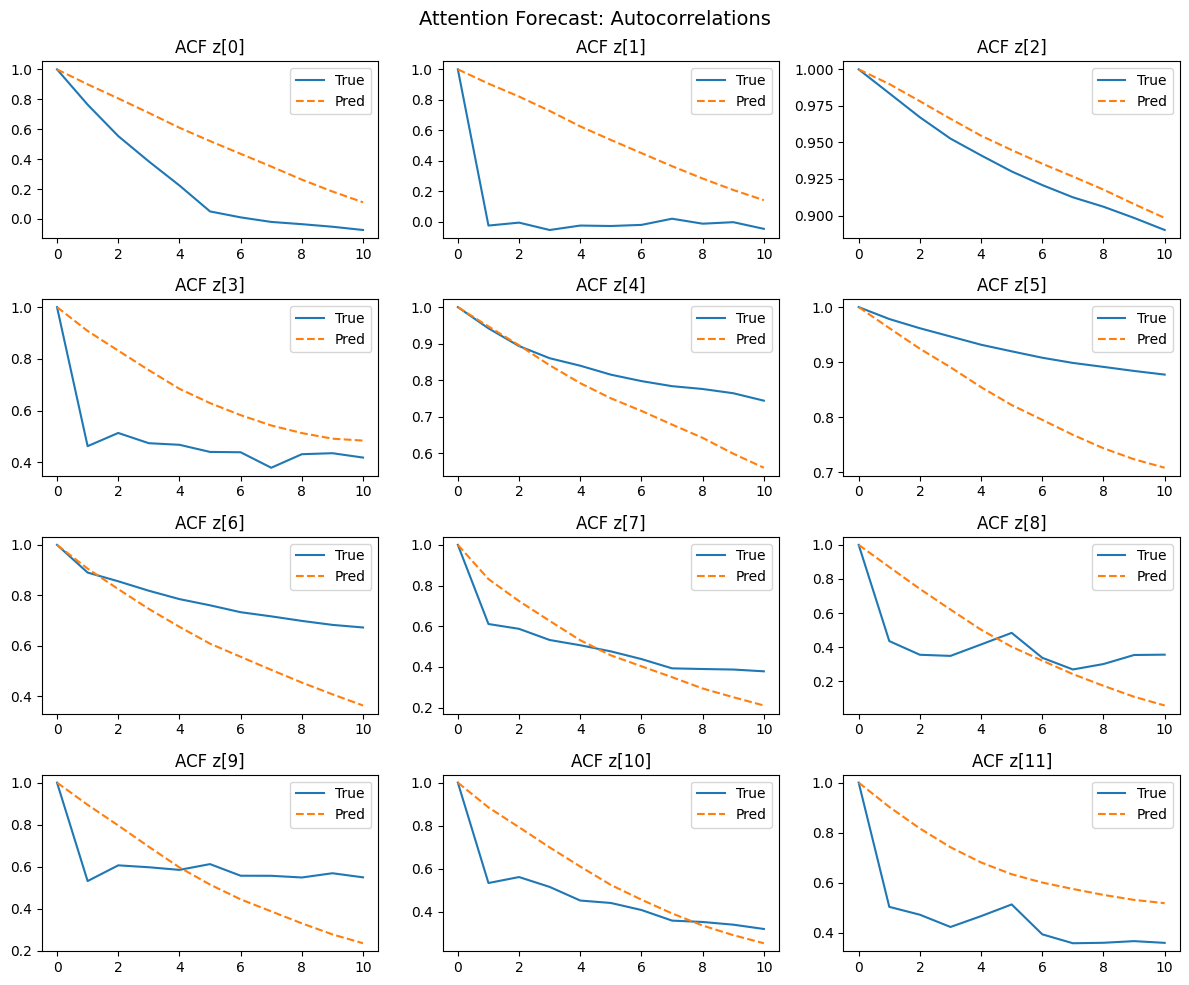

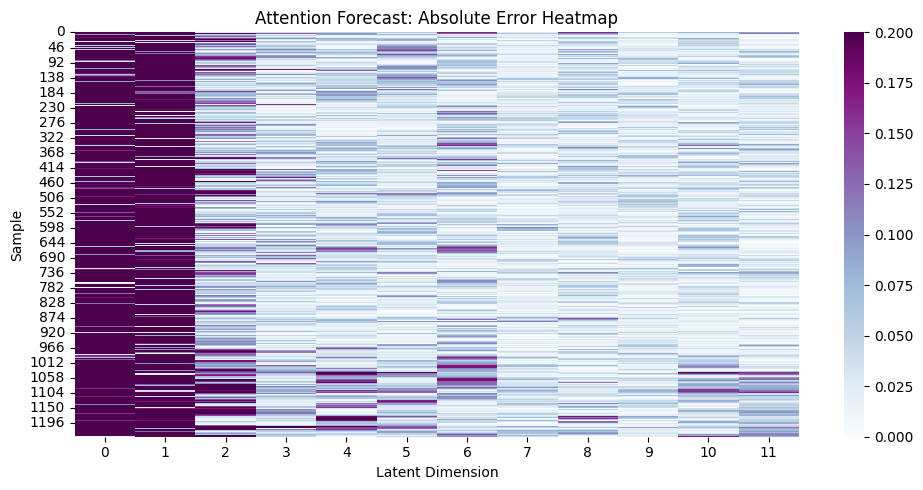

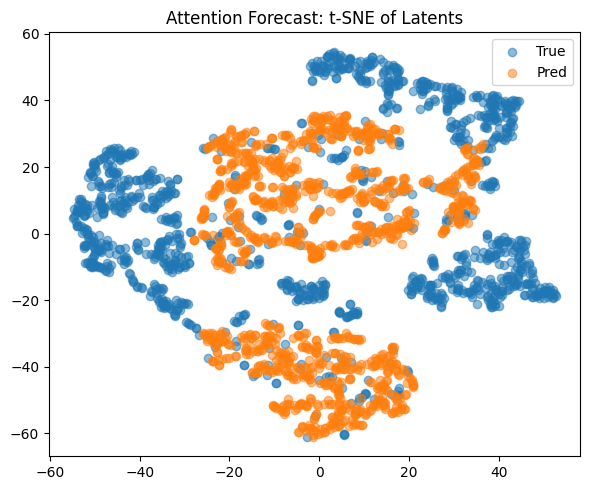

In [21]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # or y_test if split
Z_pred = attention_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_attention = summarize_latent_errors(Z_true, Z_pred, name="Attention-only PCA")
display(summary_attention)

plot_latent_diagnostics(Z_true, Z_pred, name="Attention Forecast", tsne=True)


In [22]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    # add summary_gru, summary_transformer, etc.
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-PCA          0.120320            0.120320   
1    LSTM w/ attn-PCA          0.144562            0.144562   
2  Attention-only PCA          0.174901            0.174901   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.918094       0.173049             0.406851   
1            0.907643       0.122971             0.258516   
2            1.134727       0.226248             0.129303   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      2.0   
1                    2.0                      2.0                      1.0   
2                    3.0                      3.0                      3.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 2.0                       1.0        1.4  
1                 1.0                       2.0        1.6  
2                 3.0                       3.0        3.0

### Transformer Model Hyperparameters

- **lookback**: Number of timesteps in the input sequence (e.g., 20 days)
- **input_dim**: Total input dimension per timestep = z_dim + feature_dim
- **latent_dim**: Output dimension = dimension of z_{t+1}
- **d_model**: Dimensionality of the model's internal representation per timestep
- **n_heads**: Number of attention heads in each self-attention layer
- **ff_dim**: Hidden dimension size inside each feedforward block
- **n_layers**: Number of stacked Transformer encoder blocks
- **dropout**: Dropout rate applied after self-attention and feedforward layers


In [23]:
import models.transformer
importlib.reload(models.transformer)
from models.transformer import TransformerForecaster

transformer_model = TransformerForecaster(
    lookback=LOOKBACK,
    input_dim=Z_aug.shape[-1],
    latent_dim=LATENT_DIM,
    d_model=128,
    n_heads=4,
    ff_dim=128,
    n_layers=6,
    dropout=0.1
)

model = TransformerForecaster(LOOKBACK, input_dim, LATENT_DIM)
model(np.zeros((1, LOOKBACK, input_dim), dtype="float32")) 
model.summary()



Model: "transformer_forecaster_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (1, 20, 64)            │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_6     │ ?                      │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block_7     │ ?                      │        83,200 │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (1, 12)                │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,012 (656.30 KB)

 Trainable params: 168,012 (656.30 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

# --- Create output directory ---
os.makedirs("saved_models/transformer", exist_ok=True)


lr= 5e-5
transformer_model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/transformer/transformer_pca.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

# --- Fit model ---
history_transformer = transformer_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)

# --- Save full model ---
transformer_model.save("saved_models/transformer/transformer_model_pca.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.2517 - val_loss: 0.2955 - learning_rate: 5.0000e-05
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.3305 - val_loss: 0.2986 - learning_rate: 5.0000e-05
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.3123 - val_loss: 0.2815 - learning_rate: 5.0000e-05
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2927 - val_loss: 0.2664 - learning_rate: 5.0000e-05
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2896 - val_loss: 0.2452 - learning_rate: 5.0000e-05
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.2758 - val_loss: 0.2448 - learning_rate: 5.0000e-05
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2665 - val_loss: 0.2304 - learning_rate: 5.0000e-05
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2630 - val_loss: 0.2240 - learning_rate: 5.0000e-05
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2505 - val_loss: 0.2155 - 

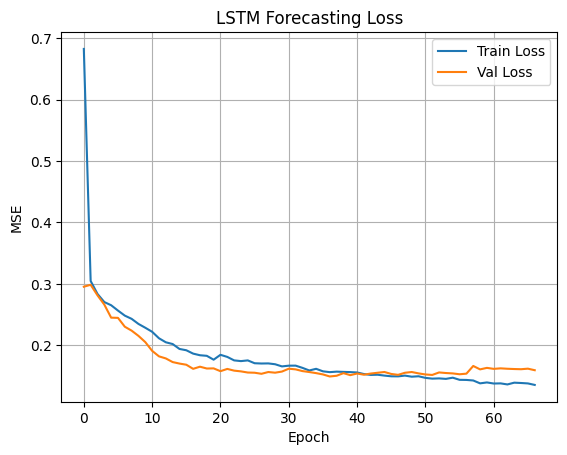

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history["loss"], label="Train Loss")
plt.plot(history_transformer.history["val_loss"], label="Val Loss")
plt.title("LSTM Forecasting Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  Transformer PCA          0.150532            0.150532            0.934201   

   acf_diff_mean  var_ratio_pred/true  
0       0.219781             0.560491

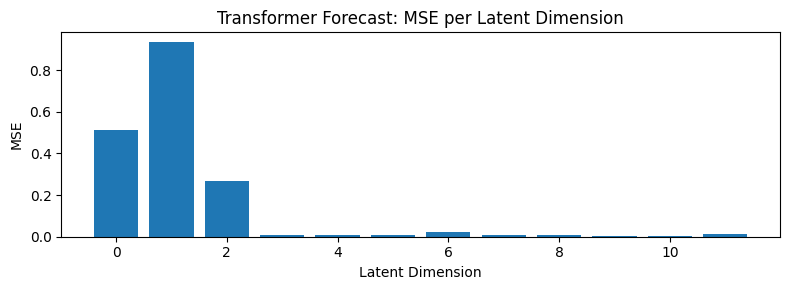

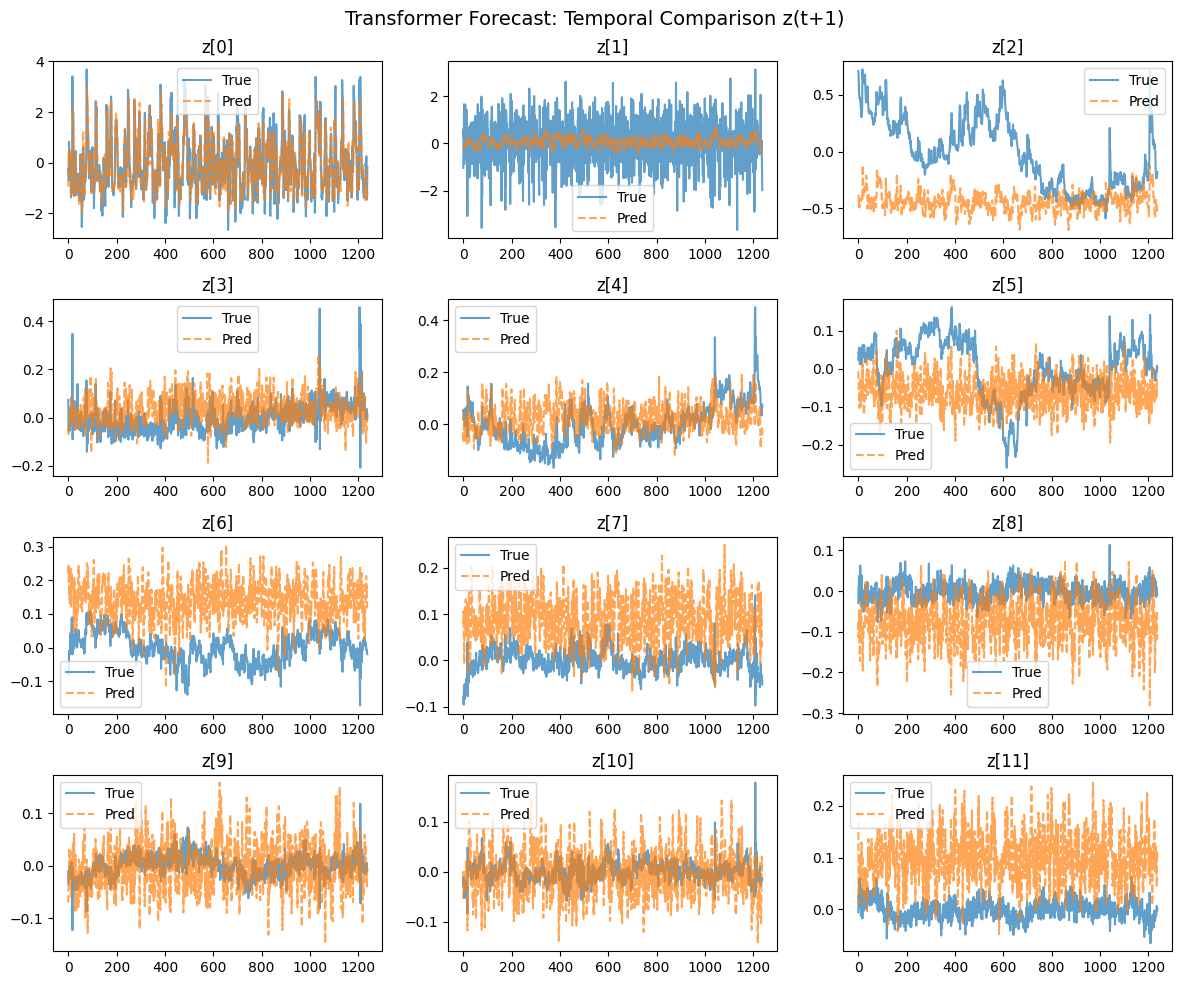

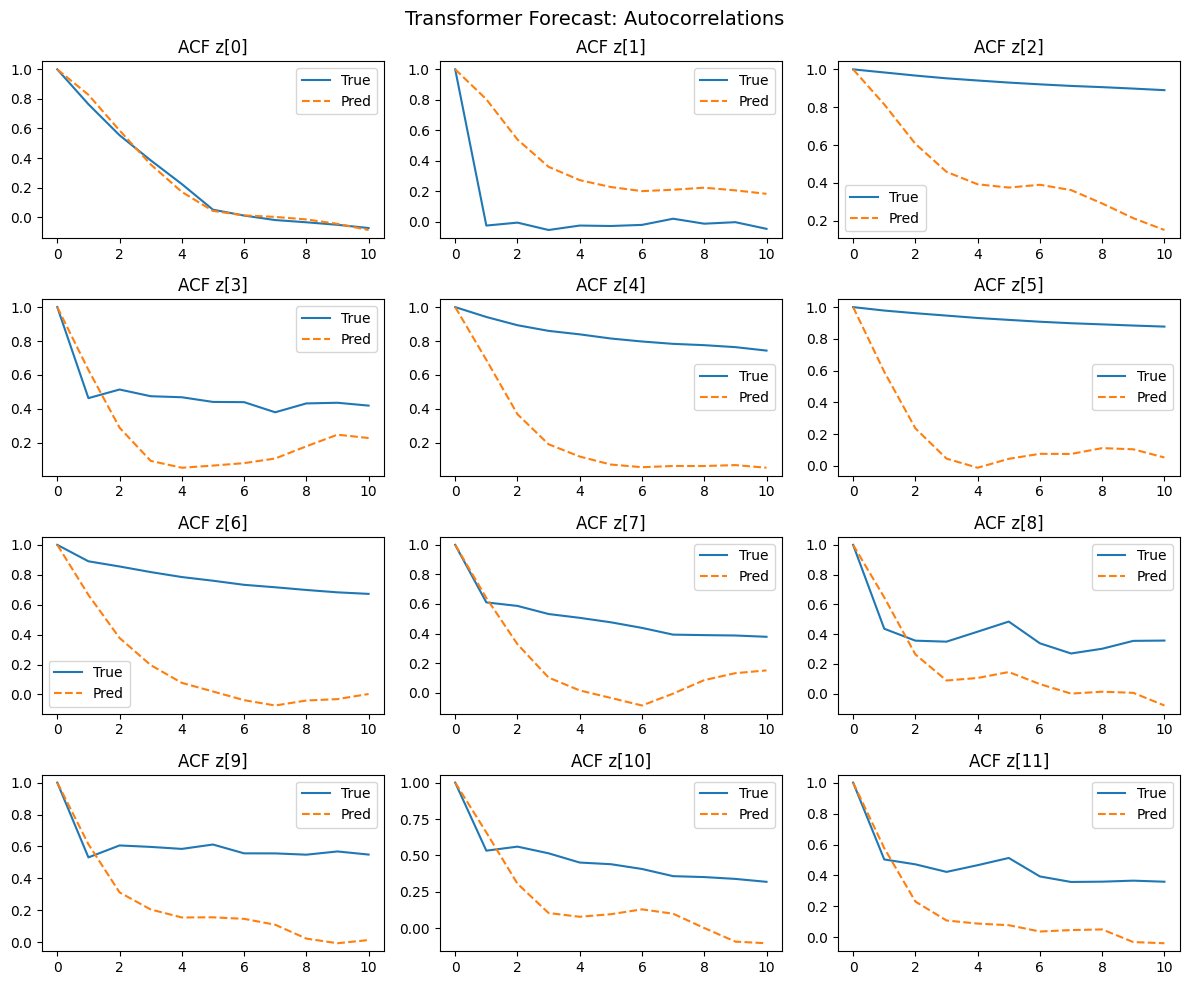

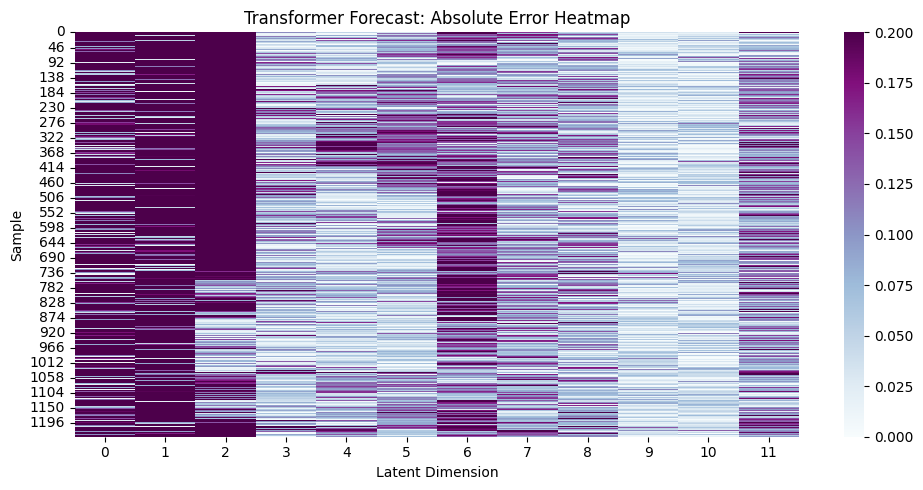

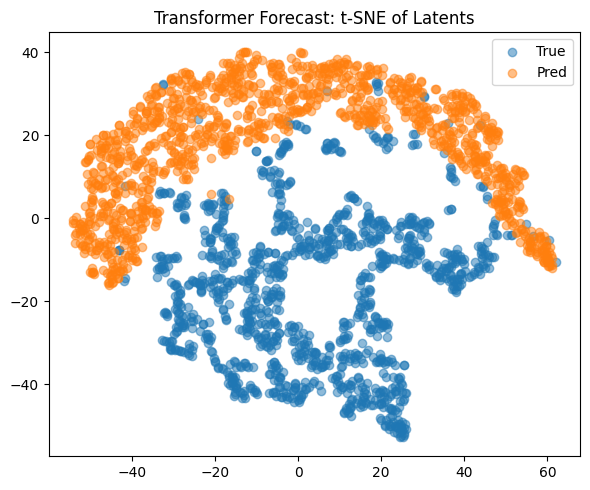

In [26]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # or y_test if using split
Z_pred = transformer_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_transformer = summarize_latent_errors(Z_true, Z_pred, name="Transformer PCA")
display(summary_transformer)

plot_latent_diagnostics(Z_true, Z_pred, name="Transformer Forecast", tsne=True)


In [27]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
    # add summary_gru, summary_transformer, etc.
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-PCA          0.120320            0.120320   
1    LSTM w/ attn-PCA          0.144562            0.144562   
2     Transformer PCA          0.150532            0.150532   
3  Attention-only PCA          0.174901            0.174901   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.918094       0.173049             0.406851   
1            0.907643       0.122971             0.258516   
2            0.934201       0.219781             0.560491   
3            1.134727       0.226248             0.129303   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      2.0   
1                    2.0                      2.0                      1.0   
2                    3.0                      3.0                      3.0   
3                    4.0                      4.0                      4.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 2.0                       2.0        1.6  
1                 1.0                       3.0        1.8  
2                 3.0                       1.0        2.6  
3                 4.0                       4.0        4.0

In [28]:
import models.transformer
importlib.reload(models.transformer)
from models.transformer import TransformerForecasterV2

transformer_model = TransformerForecasterV2(
    lookback=LOOKBACK,
    input_dim=Z_aug.shape[-1],
    latent_dim=LATENT_DIM,
    d_model=128,
    n_heads=4,
    ff_dim=256,
    n_layers=6,
    dropout=0.1
)

# Force build for summary
dummy_input = np.zeros((1, LOOKBACK, Z_aug.shape[-1]), dtype="float32")
transformer_model(dummy_input)

transformer_model.summary()


Model: "transformer_forecaster_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (1, 20, 128)           │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (20, 128)              │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_9          │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_18          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_19          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (1, 20, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_10         │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (1, 20, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_11         │ (1, 20, 128)           │       263,808 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_23          │ (1, 20, 128)           │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (1, 20, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,987,212 (7.58 MB)

 Trainable params: 1,987,212 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam


os.makedirs("saved_models/transformer_v2", exist_ok=True)

lr = 1e-5
transformer_model.compile(optimizer=Adam(learning_rate=lr), loss="mse")


callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/transformer_v2/transformer_v2.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

history_transformer_v2 = transformer_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)


transformer_model.save("saved_models/transformer_v2/transformer_v2_model.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.1358 - val_loss: 1.3612 - learning_rate: 1.0000e-05
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.0311 - val_loss: 0.7184 - learning_rate: 1.0000e-05
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.5970 - val_loss: 0.5492 - learning_rate: 1.0000e-05
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.4246 - val_loss: 0.4563 - learning_rate: 1.0000e-05
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.3126 - val_loss: 0.4136 - learning_rate: 1.0000e-05
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.2121 - val_loss: 0.3644 - learning_rate: 1.0000e-05
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1912 - val_loss: 0.3351 - learning_rate: 1.0000e-05
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.1335 - val_loss: 0.3323 - learning_rate: 1.0000e-05
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0312 - val_loss: 0.3026 - 

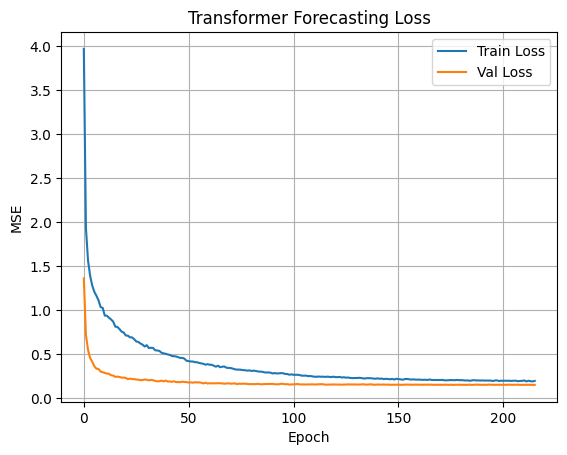

In [30]:
import matplotlib.pyplot as plt

plt.plot(history_transformer_v2.history["loss"], label="Train Loss")
plt.plot(history_transformer_v2.history["val_loss"], label="Val Loss")
plt.title("Transformer Forecasting Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


model  latent_mse_total  latent_mse_avg_dim  \
0  Transformer_v2 PCA          0.127576            0.127576   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  
0            0.907157       0.355691             0.367638

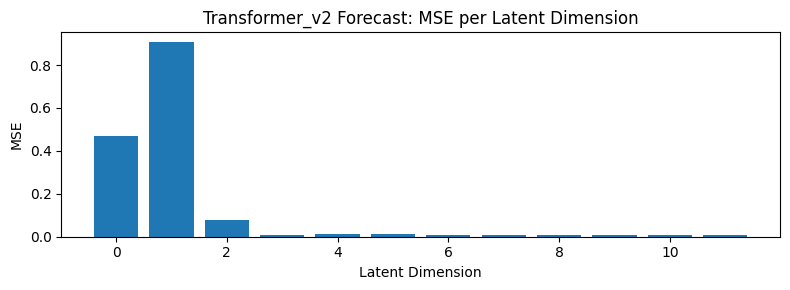

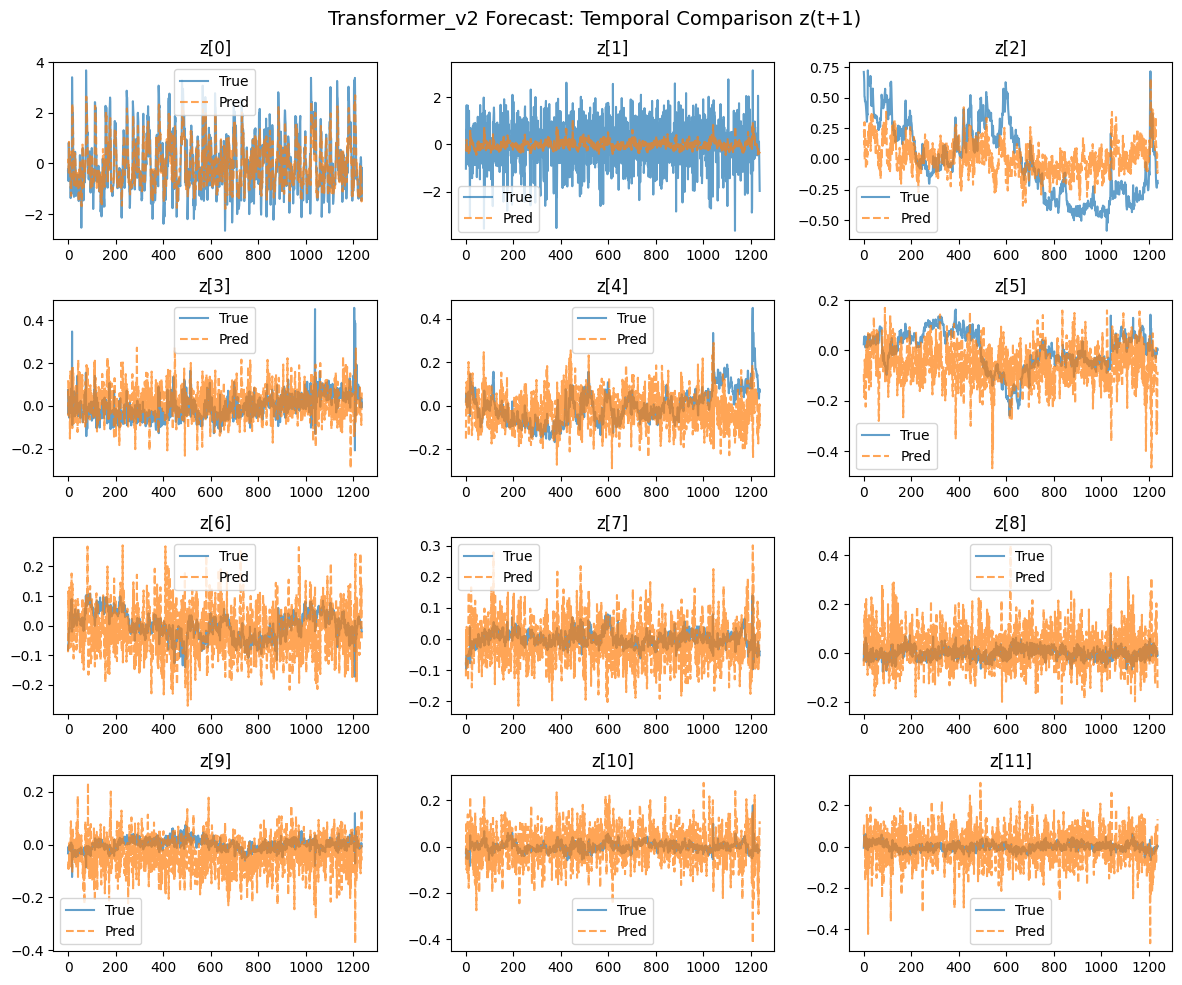

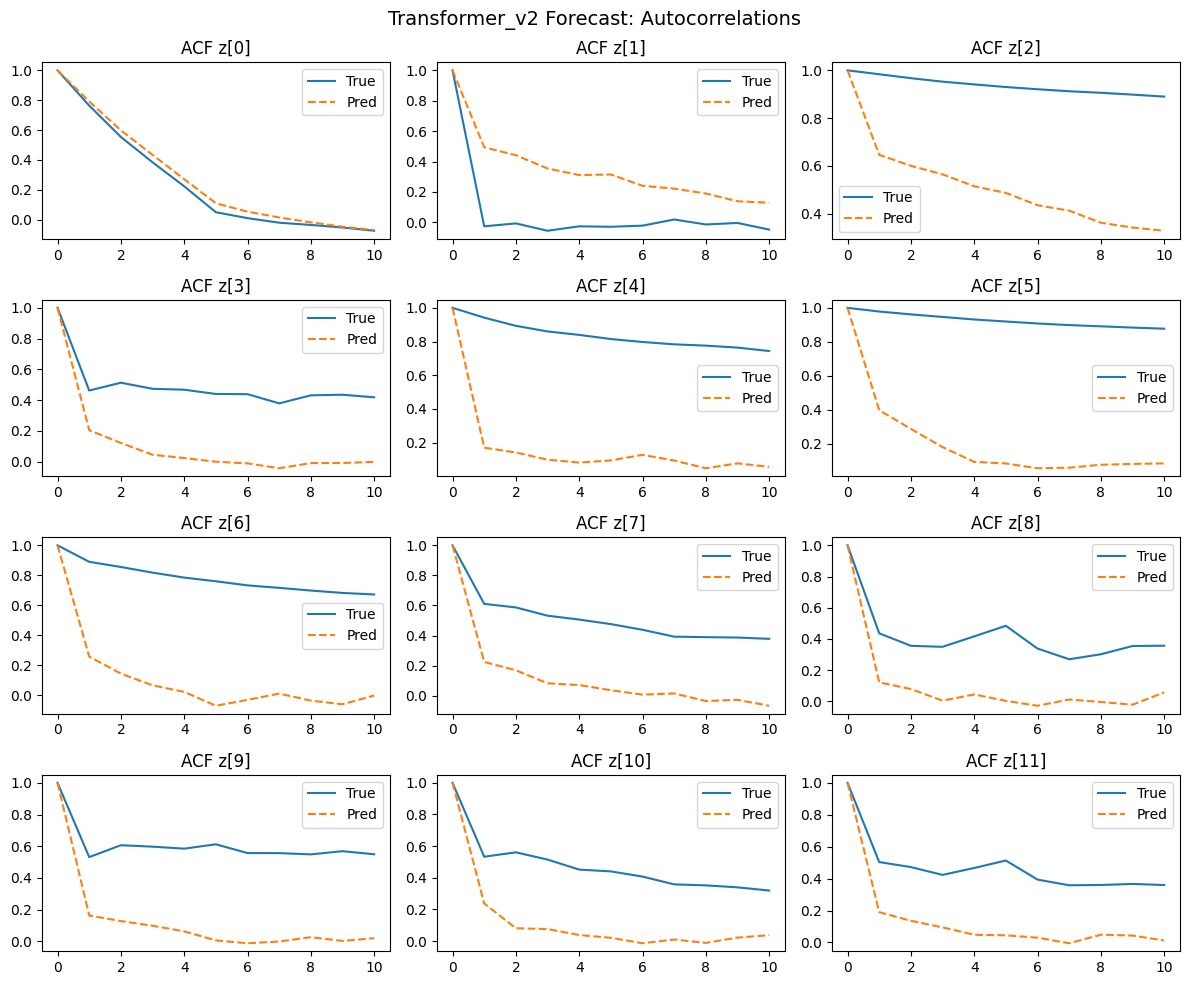

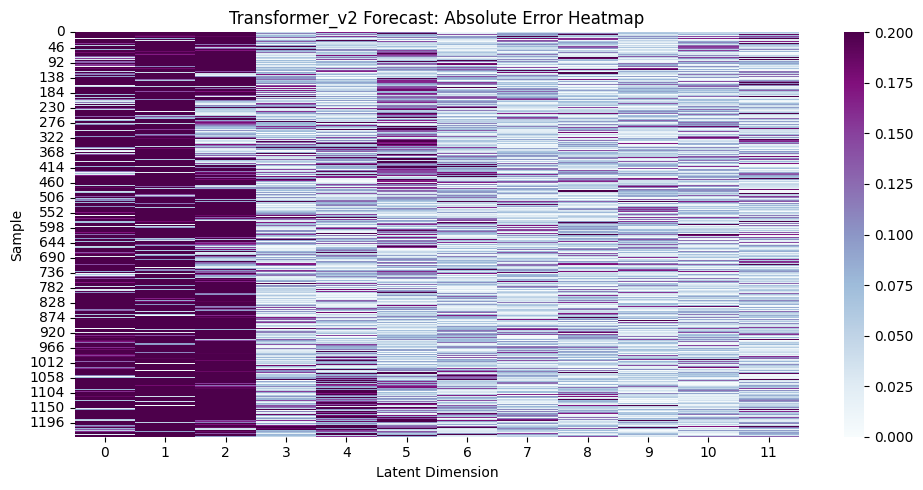

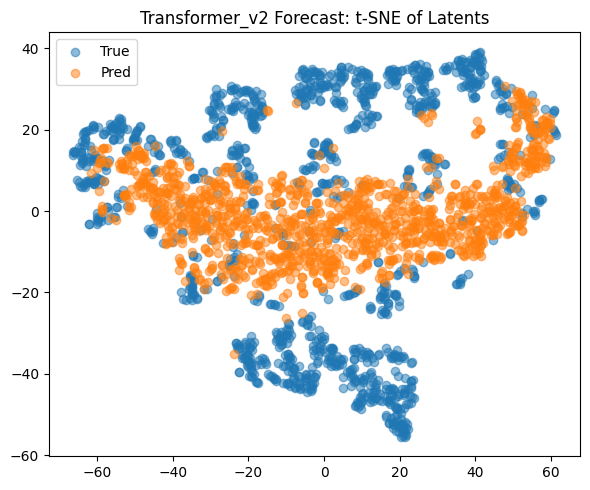

In [31]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # or y_test if using split
Z_pred = transformer_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_transformer_v2 = summarize_latent_errors(Z_true, Z_pred, name="Transformer_v2 PCA")
display(summary_transformer_v2)

plot_latent_diagnostics(Z_true, Z_pred, name="Transformer_v2 Forecast", tsne=True)


In [32]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
    summary_transformer_v2
    
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0            LSTM-PCA          0.120320            0.120320   
1  Transformer_v2 PCA          0.127576            0.127576   
2    LSTM w/ attn-PCA          0.144562            0.144562   
3     Transformer PCA          0.150532            0.150532   
4  Attention-only PCA          0.174901            0.174901   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.918094       0.173049             0.406851   
1            0.907157       0.355691             0.367638   
2            0.907643       0.122971             0.258516   
3            0.934201       0.219781             0.560491   
4            1.134727       0.226248             0.129303   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      3.0   
1                    2.0                      2.0                      1.0   
2                    3.0                      3.0                      2.0   
3                    4.0                      4.0                      4.0   
4                    5.0                      5.0                      5.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 2.0                       2.0        1.8  
1                 5.0                       3.0        2.6  
2                 1.0                       4.0        2.6  
3                 3.0                       1.0        3.2  
4                 4.0                       5.0        4.8

In [36]:
import importlib
import models.gru
importlib.reload(models.gru)

from models.gru import build_gru_forecaster_augmented

gru_model = build_gru_forecaster_augmented(
    lookback=LOOKBACK,
    input_dim=Z_aug.shape[-1],
    latent_dim=LATENT_DIM,
    lr=5e-4
)
gru_model.summary()


Model: "gru_forecaster_augmented_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ delta_z (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_z_out (Add)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from models.gru import build_gru_forecaster_augmented


os.makedirs("saved_models/gru", exist_ok=True)

# --- Build GRU model ---
gru_model = build_gru_forecaster_augmented(
    lookback=LOOKBACK,
    input_dim=Z_aug.shape[-1],
    latent_dim=LATENT_DIM,
    lr=5e-4
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.66, patience=10, verbose=0),
    ModelCheckpoint("saved_models/gru/gru_pca.weights.h5",
                    monitor="val_loss", save_best_only=True, save_weights_only=True, mode="min")
]

history_gru = gru_model.fit(
    X_seq, y_seq,
    batch_size=BATCH_SIZE,
    epochs=300,
    validation_split=0.2,
    shuffle=False,
    callbacks=callbacks,
    verbose=1
)


gru_model.save("saved_models/gru/gru_model_pca.keras")


Epoch 1/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2129 - val_loss: 0.2247 - learning_rate: 5.0000e-04
Epoch 2/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2002 - val_loss: 0.2073 - learning_rate: 5.0000e-04
Epoch 3/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1810 - val_loss: 0.1732 - learning_rate: 5.0000e-04
Epoch 4/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1465 - val_loss: 0.1436 - learning_rate: 5.0000e-04
Epoch 5/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1245 - val_loss: 0.1398 - learning_rate: 5.0000e-04
Epoch 6/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1197 - val_loss: 0.1381 - learning_rate: 5.0000e-04
Epoch 7/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1175 - val_loss: 0.1377 - learning_rate: 5.0000e-04
Epoch 8/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1167 - val_loss: 0.1374 - learning_rate: 5.0000e-04
Epoch 9/300
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1161 - val_loss: 0.1373 - 

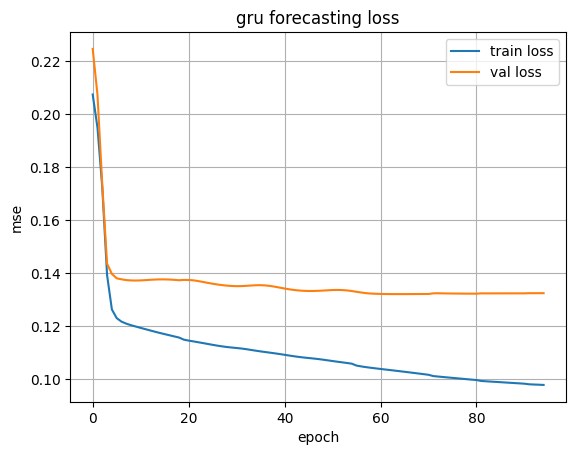

In [38]:
import matplotlib.pyplot as plt

plt.plot(history_gru.history["loss"], label="train loss")
plt.plot(history_gru.history["val_loss"], label="val loss")
plt.title("gru forecasting loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid()
plt.show()

model  latent_mse_total  latent_mse_avg_dim  latent_mse_max_dim  \
0  GRU-PCA          0.108135            0.108135             0.86112   

   acf_diff_mean  var_ratio_pred/true  
0       0.027685             0.469658

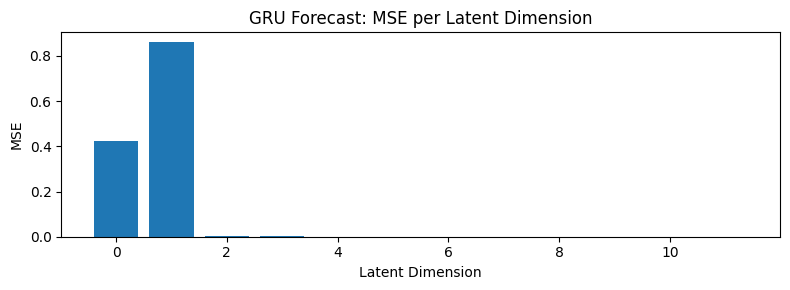

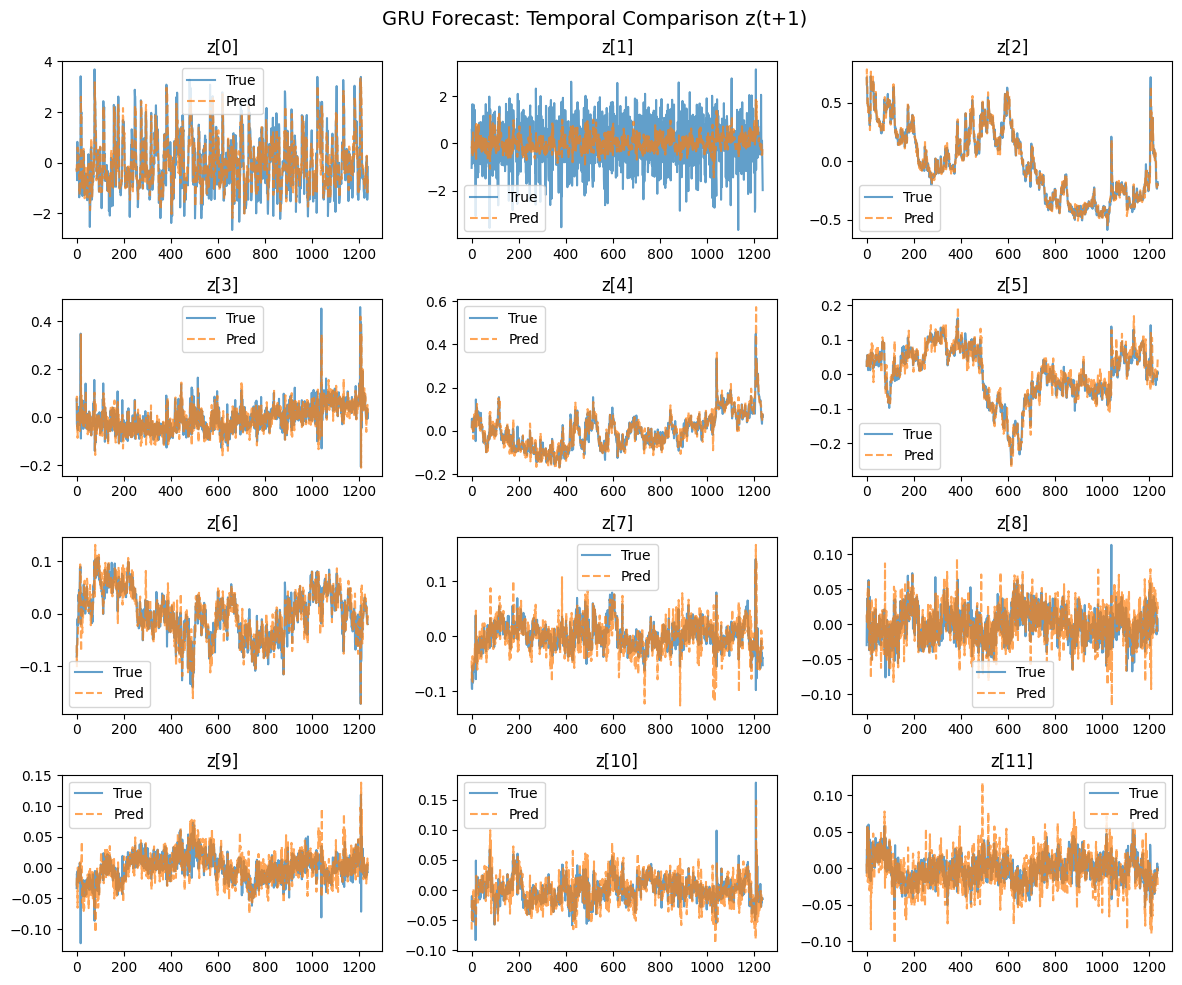

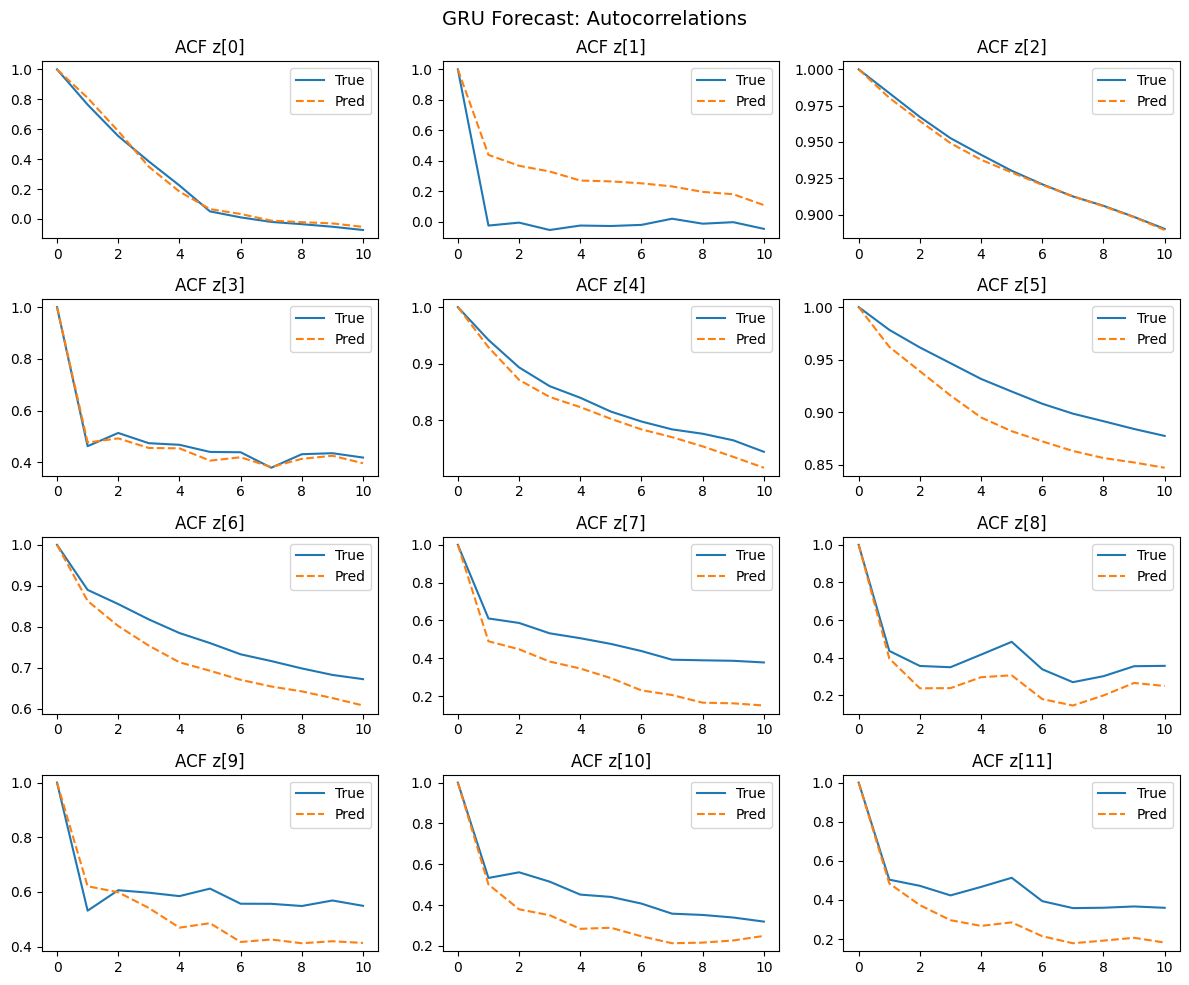

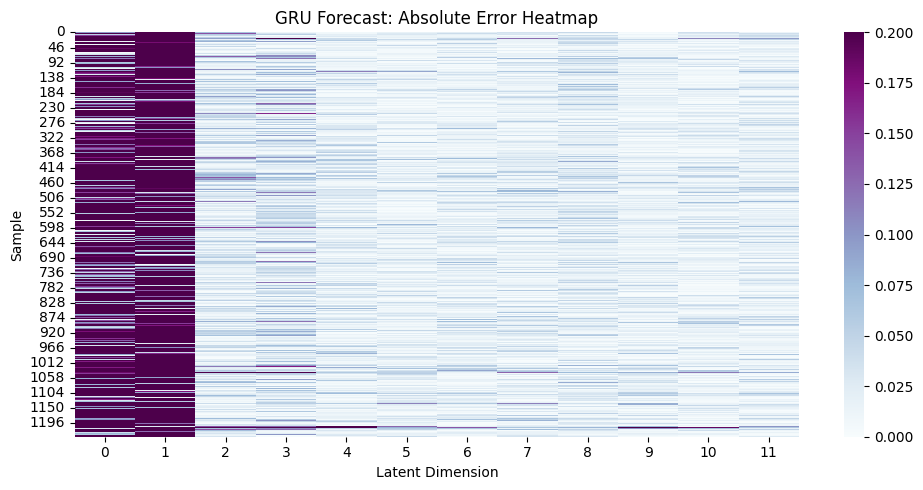

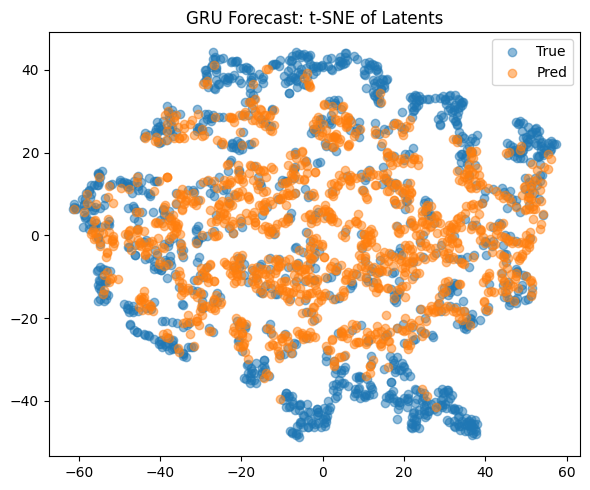

In [39]:
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import plot_latent_diagnostics

Z_true = y_seq  # or y_test if using split
Z_pred = gru_model.predict(X_seq, verbose=0)

from utils.eval import summarize_latent_errors
summary_gru = summarize_latent_errors(Z_true, Z_pred, name="GRU-PCA")
display(summary_gru)

plot_latent_diagnostics(Z_true, Z_pred, name="GRU Forecast", tsne=True)


In [40]:
import utils.eval
importlib.reload(utils.eval)



def collect_model_summaries(*summaries):
    return pd.concat(summaries, ignore_index=True).sort_values("latent_mse_total")



summary_all = collect_model_summaries(
    summary_lstm,
    summary_lstm_attn,
    summary_attention,
    summary_transformer,
    summary_transformer_v2,
    summary_gru,
    # add summary_gru, summary_transformer, etc.
)

from utils.eval import rank_temporal_model_summaries

ranked_summary = rank_temporal_model_summaries(summary_all)
display(ranked_summary)




model  latent_mse_total  latent_mse_avg_dim  \
0             GRU-PCA          0.108135            0.108135   
1            LSTM-PCA          0.120320            0.120320   
2  Transformer_v2 PCA          0.127576            0.127576   
3    LSTM w/ attn-PCA          0.144562            0.144562   
4     Transformer PCA          0.150532            0.150532   
5  Attention-only PCA          0.174901            0.174901   

   latent_mse_max_dim  acf_diff_mean  var_ratio_pred/true  \
0            0.861120       0.027685             0.469658   
1            0.918094       0.173049             0.406851   
2            0.907157       0.355691             0.367638   
3            0.907643       0.122971             0.258516   
4            0.934201       0.219781             0.560491   
5            1.134727       0.226248             0.129303   

   latent_mse_total_rank  latent_mse_avg_dim_rank  latent_mse_max_dim_rank  \
0                    1.0                      1.0                      1.0   
1                    2.0                      2.0                      4.0   
2                    3.0                      3.0                      2.0   
3                    4.0                      4.0                      3.0   
4                    5.0                      5.0                      5.0   
5                    6.0                      6.0                      6.0   

   acf_diff_mean_rank  var_ratio_pred/true_rank  mean_rank  
0                 1.0                       2.0        1.2  
1                 3.0                       3.0        2.8  
2                 6.0                       4.0        3.6  
3                 2.0                       5.0        3.6  
4                 4.0                       1.0        4.0  
5                 5.0                       6.0        5.8